In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Configure plots

In [3]:
# Set up plot size
plt.rcParams["figure.figsize"] = [10, 6]
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

## Define functions

In [4]:
# function to find element
# closest to given target using binary search.

# Returns element closest to target in arr[]
def findClosest(target, plasmid_name):

    # Expected insertion sites 
    my_expected_IS = {'original':[140,198,357,1626,2005,2214,2410,2578],
                      'modified':[148,206,365,1634,2013,2222,2418,2586]}

    arr = my_expected_IS[plasmid_name]
    #print(f'plasmid name={plasmid_name} ; coords={arr}')
    n = len(arr)
 
    # Corner cases
    if (target <= arr[0]):
        return arr[0]
    if (target >= arr[n - 1]):
        return arr[n - 1]

    # Doing binary search
    i = 0; j = n; mid = 0
    
    while (i < j):
        mid = (i + j) // 2

        
        if (arr[mid] == target):
            return arr[mid]

        # If target is less than array
        # element, then search in left
        if (target < arr[mid]) :

            # If target is greater than previous
            # to mid, return closest of two
            if (mid > 0 and target > arr[mid - 1]):
                return getClosest(arr[mid - 1], arr[mid], target)

            # Repeat for left half
            j = mid

        # If target is greater than mid
        else :
            if (mid < n - 1 and target < arr[mid + 1]):
                return getClosest(arr[mid], arr[mid + 1], target)

            # update i
            i = mid + 1

    # Only single element left after search
    return arr[mid]

# Method to compare which one is the more close.
# We find the closest by taking the difference
# between the target and both values. It assumes
# that val2 is greater than val1 and target lies
# between these two.
def getClosest(val1, val2, target):

    if (target - val1 >= val2 - target):
        return val2
    else:
        return val1


In [5]:

def predict_IS(my_blast_hit, is_coord, PlasmidName):
    #if my_blast_hit.loc[0,'s_end3'] < my_blast_hit.loc[1,'s_end5']:
    #    # negative strand
    #    print(abs(my_blast_hit.loc[0,'s_end3'] - my_blast_hit.loc[1,'s_end5']))
    #    exit(1)
        
    if (my_blast_hit.loc[0]['r_end5'] <= 5) and (my_blast_hit.loc[0]['r_end3'] >= 45):
        # Match is OK
        IS_predicted = my_blast_hit.loc[0][is_coord]
        IS_expected = findClosest(IS_predicted, plasmid_name=PlasmidName)
        my_distance = abs(IS_predicted - IS_expected)
        return(IS_predicted,IS_expected,my_distance)
    else:
        #print(my_blast_hit[['read_id','r_end5','r_end3','s_end5','s_end3','q_len','s_len']])
        return(None,None,None)

In [6]:
# 1- Load blastn results from file
def upload_blastn_tab_file(blastn_file):
    my_df = pd.read_csv(filepath_or_buffer=blastn_file, delimiter="\t", header=None)
    
    # Split 1st column based on ":" and "-" characters
    new = my_df[0].str.split(':', expand = True)
    coords = new[1].str.split('-', expand = True)
    my_df = pd.concat([new[0], coords, my_df[range(1,len(my_df.columns))]], join = 'outer', axis = 1).copy()
    
    my_df.columns = ['read_id','r_coord5','r_coord3','plasmid_id','p_id','hit_len',
                              'mismatch','gaps','r_end5','r_end3','s_end5','s_end3','q_len',
                              's_len','evalue'] # blastn needs query and subject length!!!! Rerun blastn
    #my_df = my_df.set_index('read_id').copy()
    return(my_df)

In [7]:
# 2- Remove reads with unique blastn hits
def remove_duplicates(blastn_df):
    blastn_df = blastn_df.query('r_end3 >= 50')
    keep = blastn_df.read_id[blastn_df.duplicated(subset='read_id')]
    blastn_df_dupl = blastn_df[blastn_df['read_id'].isin(keep)]
    return(blastn_df_dupl)

In [8]:
# 3- Identify and quantify IS sites
def quantify_IS_sites(blastn_df, plasmid_name, my_bed_df): # plasmid_name = ['original','modified']
    plasmid_coords = {'original':{140:6,198:7,357:8,1626:1,2005:2,2214:3,2410:4,2578:5},
                   'modified':{148:6,206:7,365:8,1634:1,2013:2,2222:3,2418:4,2586:5}
                     }
    
    
    if plasmid_name in ['modified','original']:
        expected_coords = plasmid_coords[plasmid_name]
        is_results_df = pd.DataFrame(columns=['read_id', 'predicted_is', 'expected_is', 'IS_number','dist_p_e'])

        pbar = tqdm(total=len(blastn_df['read_id'].unique()), desc='Counting IS sites')
        
        for qid in blastn_df['read_id'].unique():
            pbar.update(1)
            
            my_hit = blastn_df.query('read_id == @qid')
            my_hit = my_hit.reset_index(drop=True)

            my_IS_coord = my_bed_df.query('read_id == @qid')
            my_IS_coord = my_IS_coord.reset_index(drop=True)

            if my_IS_coord['is_coord'][0] == my_IS_coord['end_5'][0]:
                IS_coord = 's_end5'
            else:
                IS_coord = 's_end3'

            IS_result = predict_IS(my_blast_hit=my_hit, is_coord=IS_coord, PlasmidName=plasmid_name)

            if IS_result[0] == None:
                continue

            is_results_df = pd.concat([is_results_df,
                                    pd.DataFrame({'read_id':qid, 
                                                  'predicted_is':[IS_result[0]],
                                                  'expected_is':IS_result[1], 
                                                  'IS_number':expected_coords[IS_result[1]],
                                                  'dist_p_e':IS_result[2]
                                                  })
                                    ])

        
        return(is_results_df)
    else:
        print(f"ERROR, you need to specify plasmid name ('modified','original'). Current={plasmid_name}")
        exit(1)
        

In [9]:
def calculate_is_frequency(my_results_df, plasmid_name):
    my_plasmid_lengths = {'original':2675, 'modified':2683}
    is_freq = pd.DataFrame(my_results_df.groupby(by='predicted_is').count()['dist_p_e'])
    
    is_freq['coords'] = is_freq.index
    is_freq.index.name=None
    is_freq.columns=['counts','coords']

    x = pd.DataFrame(data={'coords_x':range(1,my_plasmid_lengths[plasmid_name])}, index=range(1,my_plasmid_lengths[plasmid_name]))
    w = pd.concat([x,is_freq],axis=1)
    w['counts'] = w['counts'].fillna(0)
    return(w)



In [10]:
def calculate_is_frequency_by_expected(my_results_df, plasmid_name):
    my_plasmid_lengths = {'original':2675, 'modified':2683}
    #is_freq = pd.DataFrame(my_results_df.groupby(by='predicted_is').count()['dist_p_e'])
    is_freq = pd.DataFrame(my_results_df.groupby(by='expected_is').count()['dist_p_e'])
    
    is_freq['coords'] = is_freq.index
    is_freq.index.name=None
    is_freq.columns=['counts','coords']

    x = pd.DataFrame(data={'coords_x':range(1,my_plasmid_lengths[plasmid_name])}, index=range(1,my_plasmid_lengths[plasmid_name]))
    w = pd.concat([x,is_freq],axis=1)
    w['counts'] = w['counts'].fillna(0)
    return(w)



## Load BC01 (original) dataset

In [11]:
#df = pd.read_csv(filepath_or_buffer='./Hickman_n2n_3_1A71_trimmed.filter.hits.flanking_vs_original.bn', delimiter="\t", header=None)
#df.columns = ['read_id','r_coord5','r_coord3','plasmid_id','p_id','hit_len','mismatch','gaps','r_end5','r_end3','s_end5','s_end3','q_len','s_len','evalue']


# Load blastn result
my_blastn_file = './SINGLE_END/BC01_trimmed.filter.hits.flanking_vs_original.NR.bn'
my_bed_file = './SINGLE_END/BC01_trimmed.filter.hits.bed'

df_orig_bc01 = upload_blastn_tab_file(blastn_file=my_blastn_file)
df_bed_bc01 = pd.read_csv(my_bed_file, sep='\t', header=None, names=['read_id','end_5','end_3','is_coord'])

# Remove reads with unique blastn hits
#df_orig_dupl = remove_duplicates(df_orig)


# Identify IS sites
is_results_orig_bc01 = quantify_IS_sites(blastn_df=df_orig_bc01, 
                                    plasmid_name='original', 
                                    my_bed_df=df_bed_bc01
                                    )

# Calculate IS frequency
my_freq_orig_bc01 = calculate_is_frequency(is_results_orig_bc01,'original')
my_freq_orig_expected_bc01 = calculate_is_frequency_by_expected(is_results_orig_bc01,'original')


Counting IS sites:   0%|          | 0/85876 [00:00<?, ?it/s]

## Make IS frequency plot

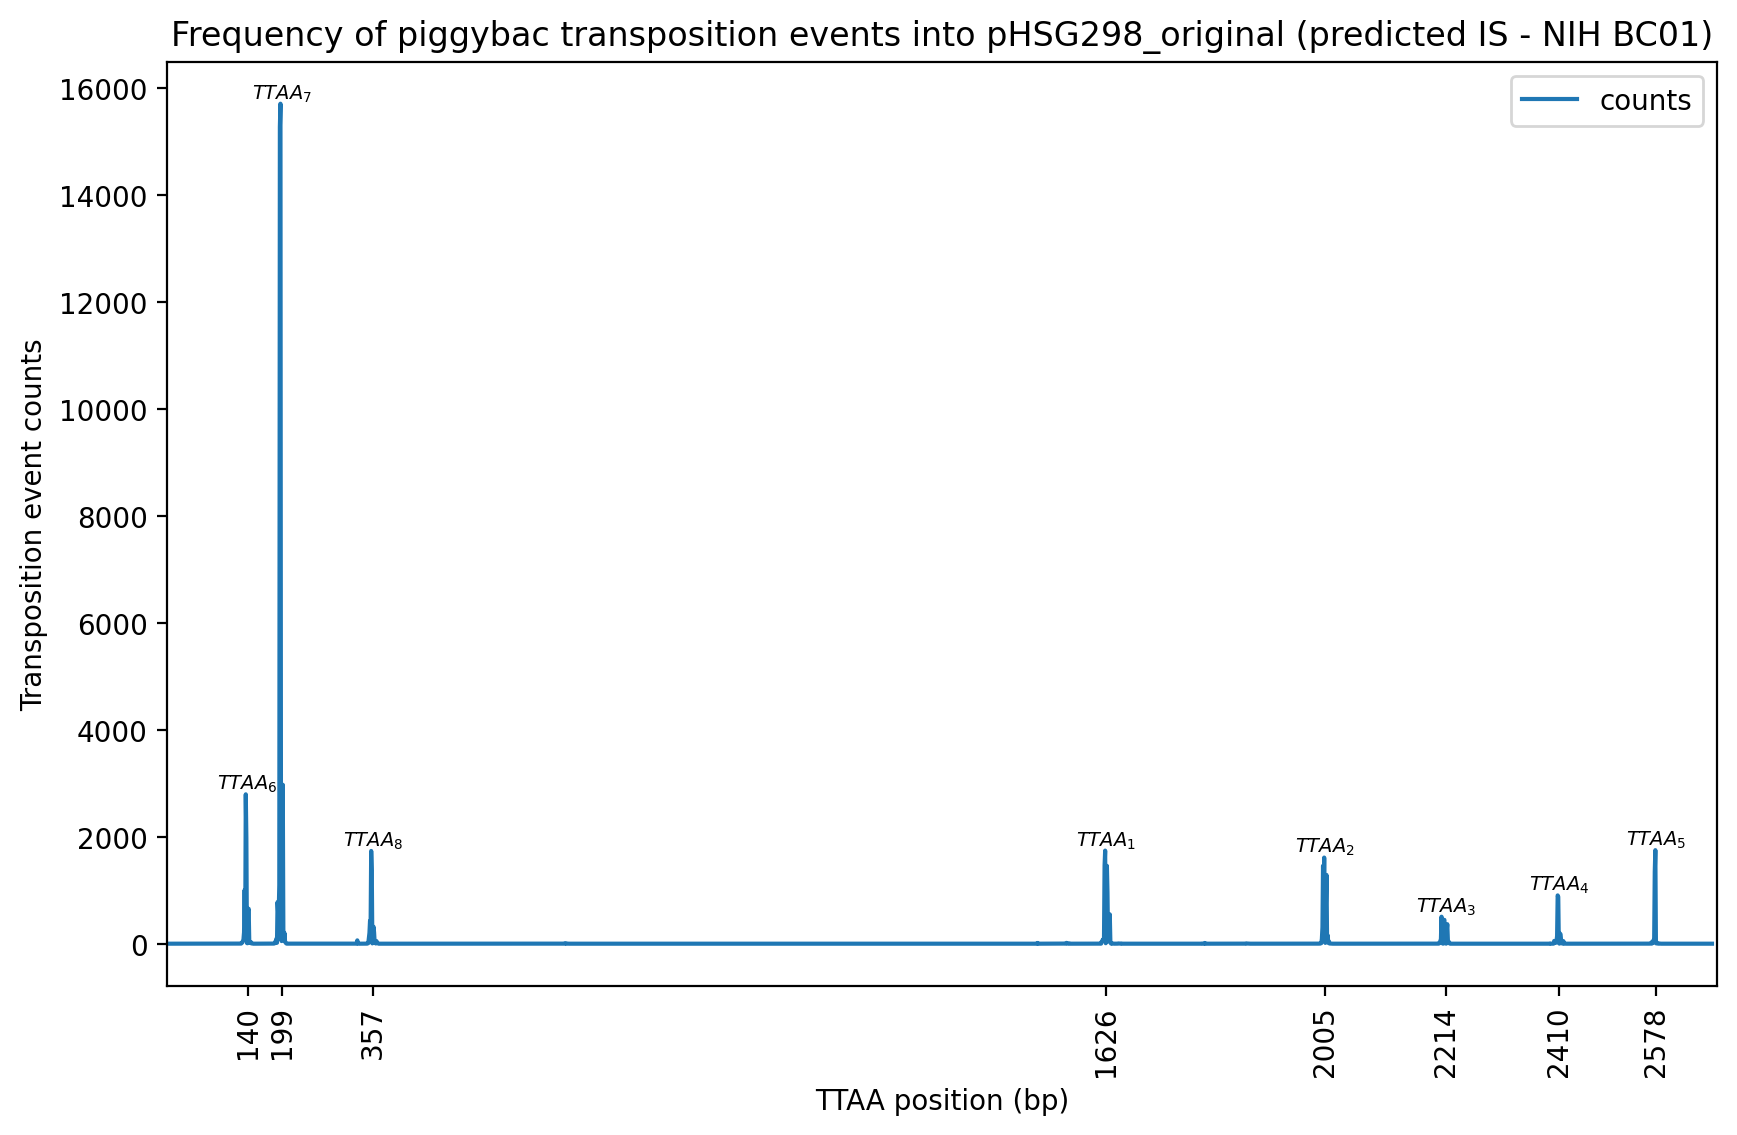

In [12]:
IS=[140,199,357,1626,2005,2214,2410,2578]

p1 = my_freq_orig_bc01.plot(x='coords_x', y='counts',
            xlabel='TTAA position (bp)', 
            ylabel='Transposition event counts', 
            xlim=(1,2683),
            xticks=(140,199,357,1626,2005,2214,2410,2578),
            rot=90
            )

p1.set_title('Frequency of piggybac transposition events into pHSG298_original (predicted IS - NIH BC01)')
p1.text(IS[0], my_freq_orig_bc01.iloc[IS[0]-10:IS[0]+10]['counts'].max() + 100, "$TTAA_6$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[1], my_freq_orig_bc01.iloc[IS[1]-10:IS[1]+10]['counts'].max() + 100, "$TTAA_7$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[2], my_freq_orig_bc01.iloc[IS[2]-10:IS[2]+10]['counts'].max() + 100, "$TTAA_8$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[3], my_freq_orig_bc01.iloc[IS[3]-10:IS[3]+10]['counts'].max() + 100, "$TTAA_1$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[4], my_freq_orig_bc01.iloc[IS[4]-10:IS[4]+10]['counts'].max() + 100, "$TTAA_2$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[5], my_freq_orig_bc01.iloc[IS[5]-10:IS[5]+10]['counts'].max() + 100, "$TTAA_3$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[6], my_freq_orig_bc01.iloc[IS[6]-10:IS[6]+10]['counts'].max() + 100, "$TTAA_4$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[7], my_freq_orig_bc01.iloc[IS[7]-10:IS[7]+10]['counts'].max() + 100, "$TTAA_5$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')

plt.show(p1)

fig = p1.get_figure()
fig.savefig('bc01_vs_original_predicted.pdf')

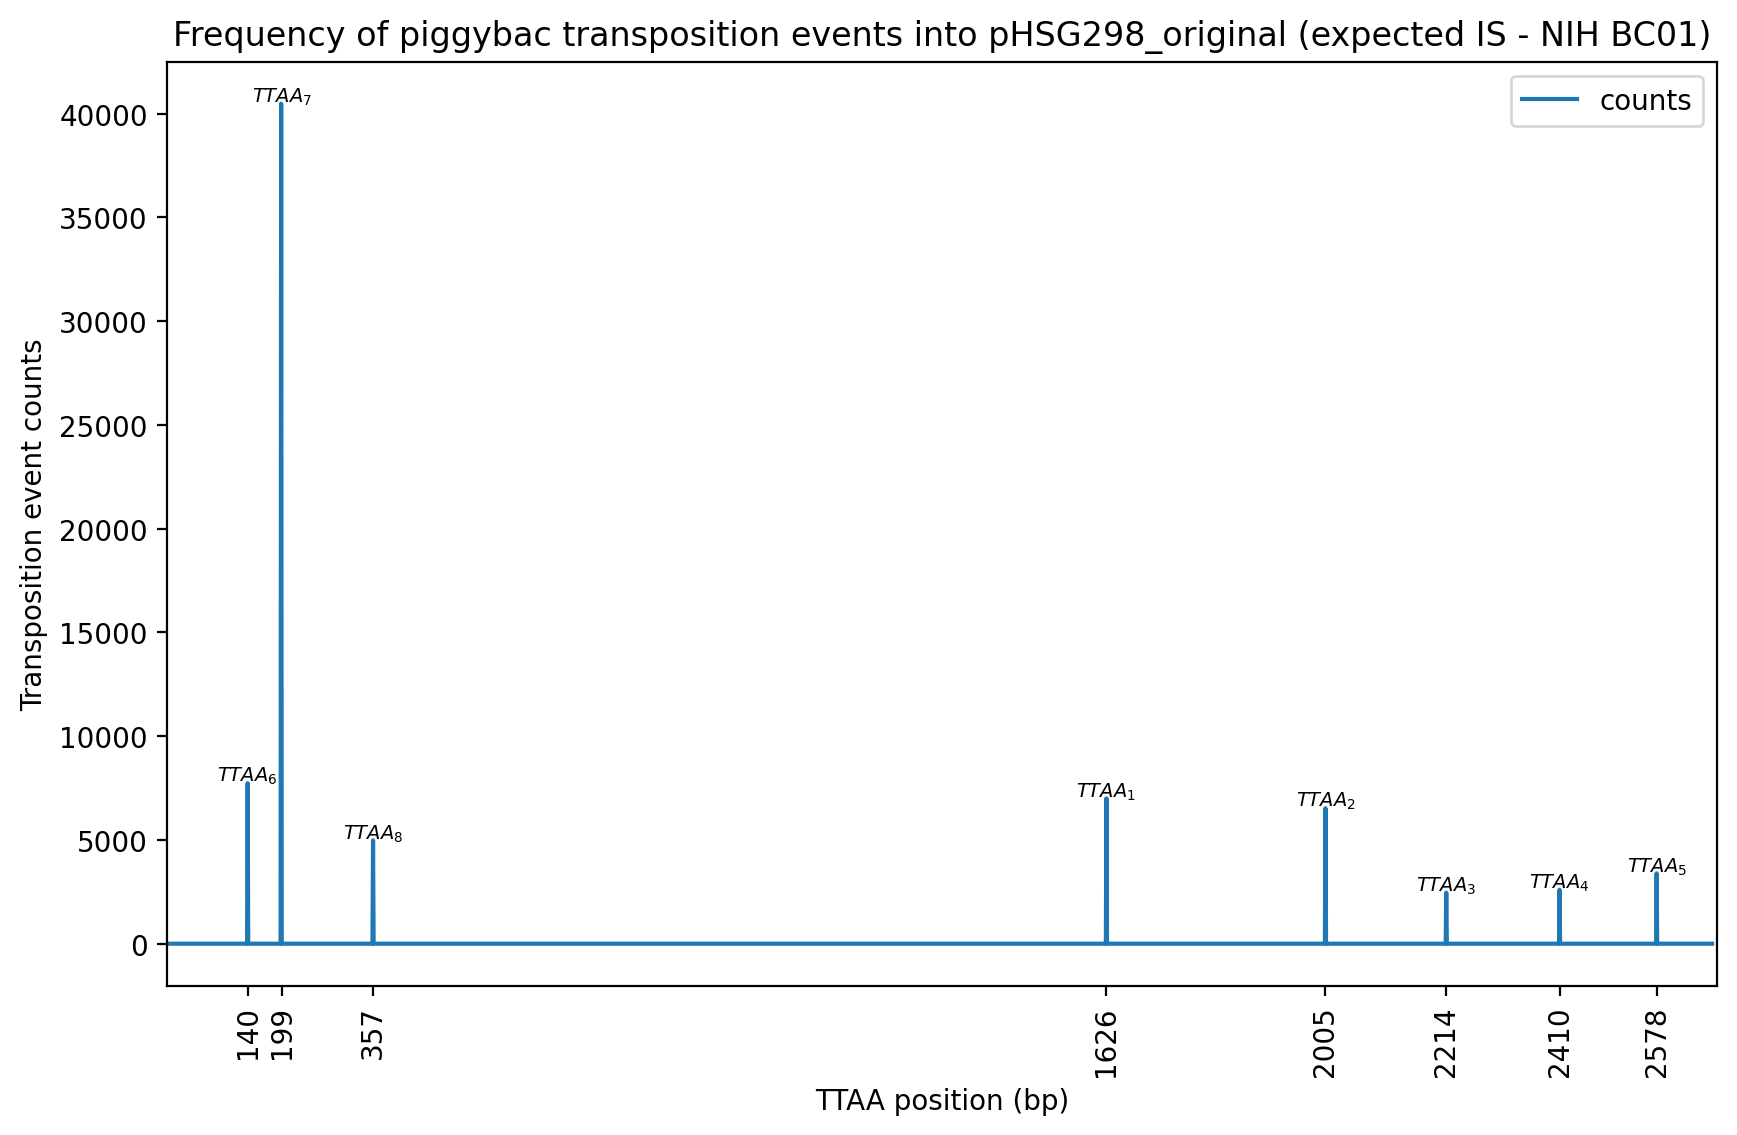

In [13]:
IS=[140,199,357,1626,2005,2214,2410,2578]

p1 = my_freq_orig_expected_bc01.plot(x='coords_x', y='counts',
            xlabel='TTAA position (bp)', 
            ylabel='Transposition event counts', 
            xlim=(1,2683),
            xticks=(140,199,357,1626,2005,2214,2410,2578),
            rot=90
            )

p1.set_title('Frequency of piggybac transposition events into pHSG298_original (expected IS - NIH BC01)')
p1.text(IS[0], my_freq_orig_expected_bc01.iloc[IS[0]-10:IS[0]+10]['counts'].max() + 100, "$TTAA_6$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[1], my_freq_orig_expected_bc01.iloc[IS[1]-10:IS[1]+10]['counts'].max() + 100, "$TTAA_7$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[2], my_freq_orig_expected_bc01.iloc[IS[2]-10:IS[2]+10]['counts'].max() + 100, "$TTAA_8$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[3], my_freq_orig_expected_bc01.iloc[IS[3]-10:IS[3]+10]['counts'].max() + 100, "$TTAA_1$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[4], my_freq_orig_expected_bc01.iloc[IS[4]-10:IS[4]+10]['counts'].max() + 100, "$TTAA_2$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[5], my_freq_orig_expected_bc01.iloc[IS[5]-10:IS[5]+10]['counts'].max() + 100, "$TTAA_3$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[6], my_freq_orig_expected_bc01.iloc[IS[6]-10:IS[6]+10]['counts'].max() + 100, "$TTAA_4$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[7], my_freq_orig_expected_bc01.iloc[IS[7]-10:IS[7]+10]['counts'].max() + 100, "$TTAA_5$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')

plt.show(p1)

fig = p1.get_figure()
fig.savefig('bc01_vs_original_expected.pdf')

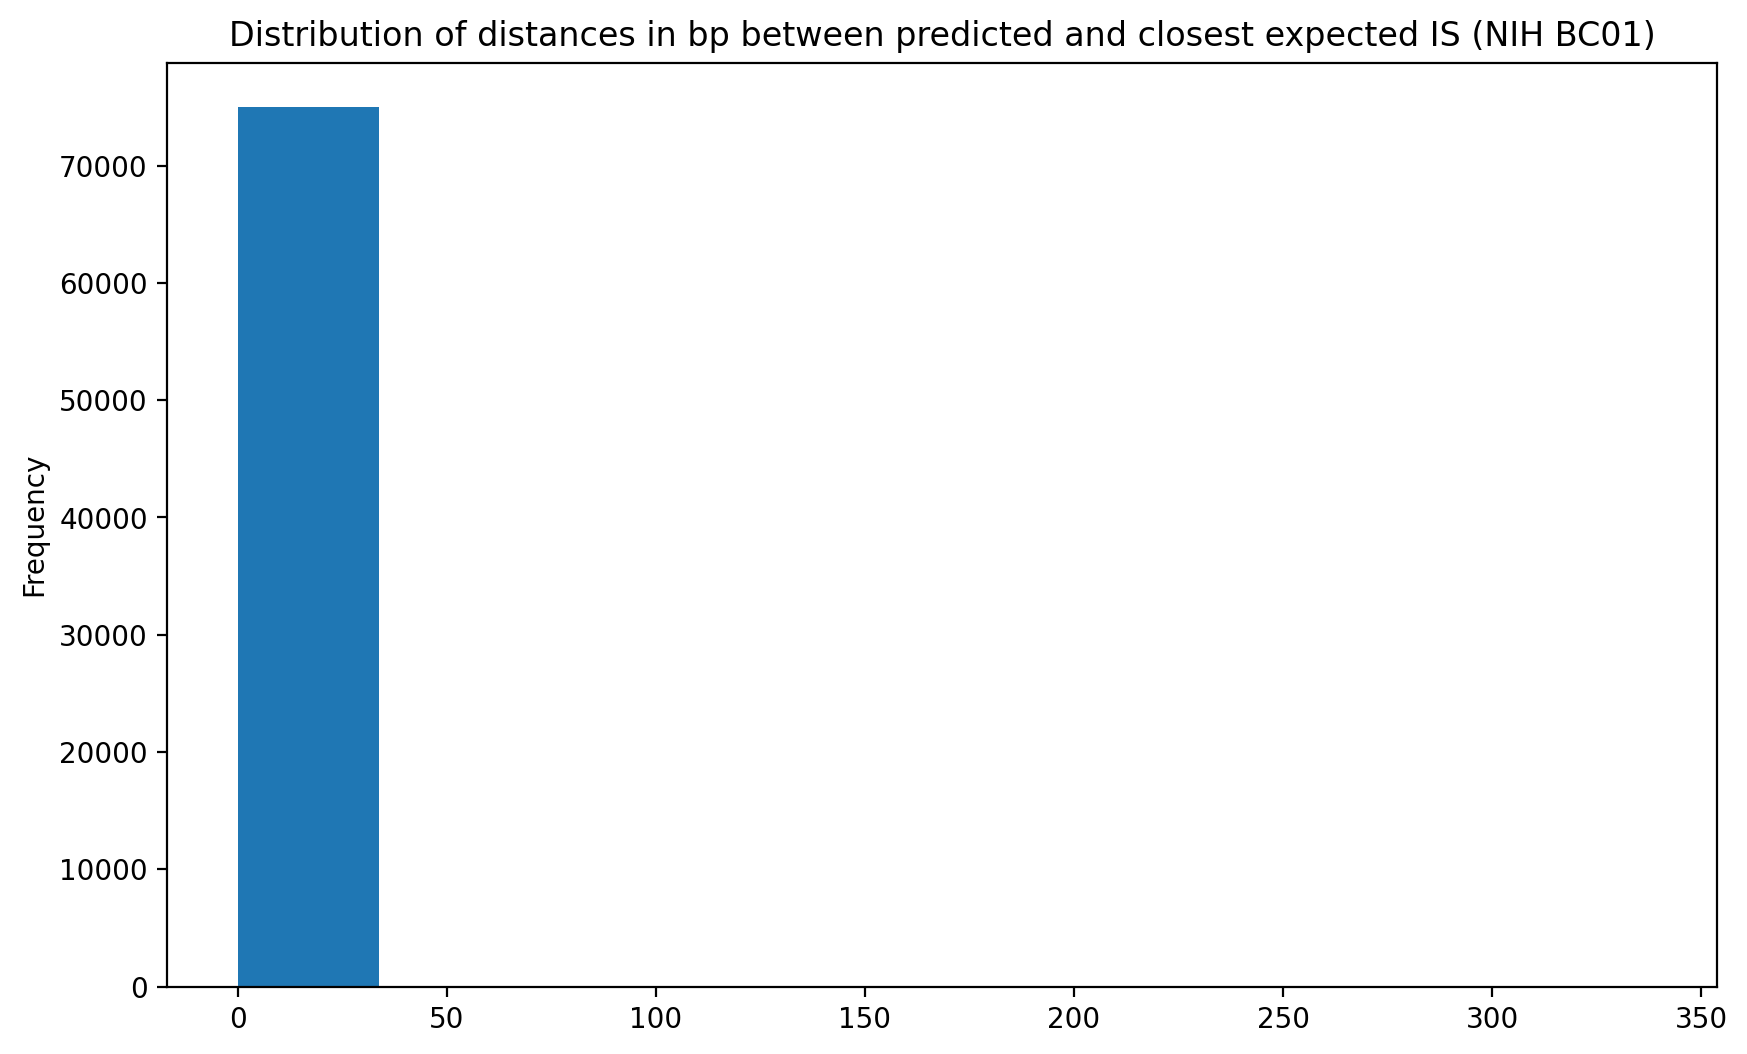

In [14]:
p1_hist = is_results_orig_bc01['dist_p_e'].plot(kind='hist', 
                                title='Distribution of distances in bp between predicted and closest expected IS (NIH BC01)',
                                xlabel='Predicted vs expected IS distance (bp)'
                            )
plt.show(p1_hist)

## Load NIH dataset BC13 (original)

In [15]:
# Load blastn result
my_blastn_file = './SINGLE_END/BC13_trimmed.filter.hits.flanking_vs_original.NR.bn'
my_bed_file = './SINGLE_END/BC13_trimmed.filter.hits.bed'

df_orig_bc13 = upload_blastn_tab_file(blastn_file=my_blastn_file)
df_bed_bc13 = pd.read_csv(my_bed_file, sep='\t', header=None, names=['read_id','end_5','end_3','is_coord'])

# Remove reads with unique blastn hits
#df_orig_dupl = remove_duplicates(df_orig)


# Identify IS sites
is_results_orig_bc13 = quantify_IS_sites(blastn_df=df_orig_bc13, 
                                    plasmid_name='original', 
                                    my_bed_df=df_bed_bc13
                                    )

# Calculate IS frequency
my_freq_orig_bc13 = calculate_is_frequency(is_results_orig_bc13,'original')
my_freq_orig_expected_bc13 = calculate_is_frequency_by_expected(is_results_orig_bc13,'original')

Counting IS sites:   0%|          | 0/2473 [00:00<?, ?it/s]

## Make IS frequency plot

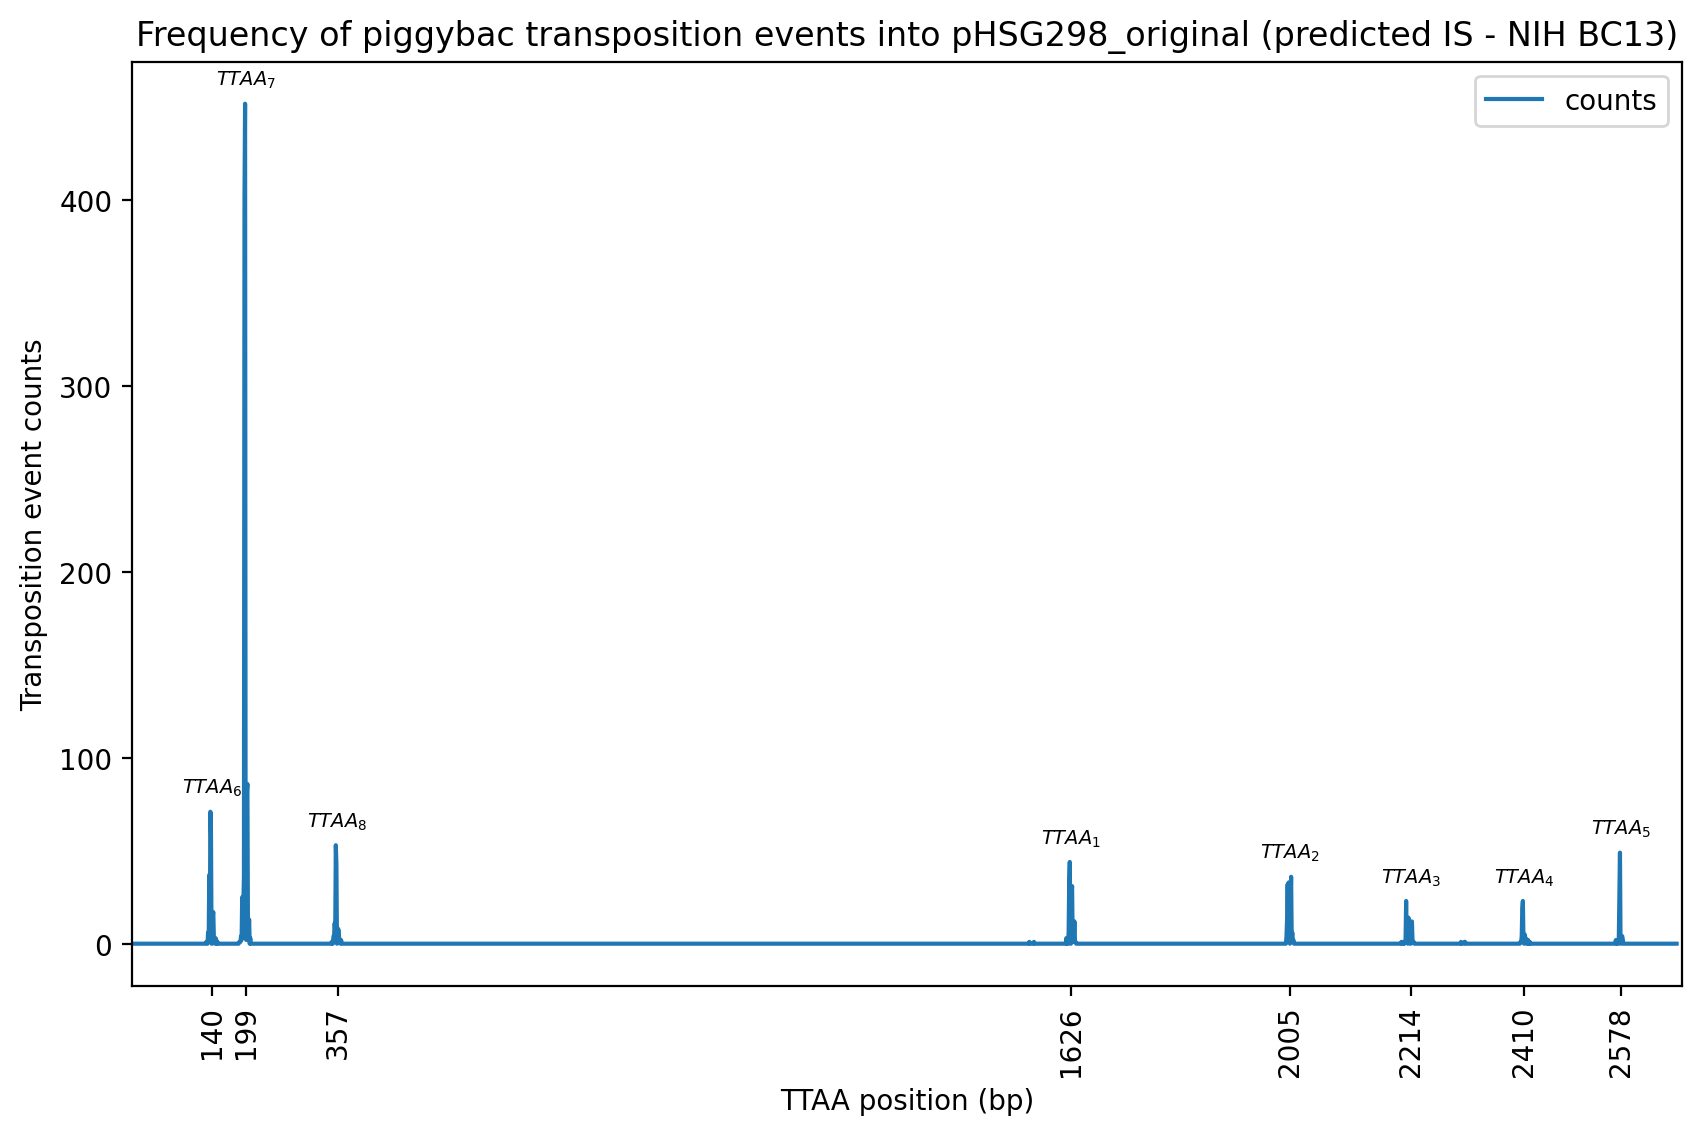

In [16]:
IS=[140,199,357,1626,2005,2214,2410,2578]

p1 = my_freq_orig_bc13.plot(x='coords_x', y='counts',
            xlabel='TTAA position (bp)', 
            ylabel='Transposition event counts', 
            xlim=(1,2683),
            xticks=(140,199,357,1626,2005,2214,2410,2578),
            rot=90
            )

p1.set_title('Frequency of piggybac transposition events into pHSG298_original (predicted IS - NIH BC13)')
p1.text(IS[0], my_freq_orig_bc13.iloc[IS[0]-10:IS[0]+10]['counts'].max() + 10, "$TTAA_6$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[1], my_freq_orig_bc13.iloc[IS[1]-10:IS[1]+10]['counts'].max() + 10, "$TTAA_7$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[2], my_freq_orig_bc13.iloc[IS[2]-10:IS[2]+10]['counts'].max() + 10, "$TTAA_8$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[3], my_freq_orig_bc13.iloc[IS[3]-10:IS[3]+10]['counts'].max() + 10, "$TTAA_1$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[4], my_freq_orig_bc13.iloc[IS[4]-10:IS[4]+10]['counts'].max() + 10, "$TTAA_2$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[5], my_freq_orig_bc13.iloc[IS[5]-10:IS[5]+10]['counts'].max() + 10, "$TTAA_3$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[6], my_freq_orig_bc13.iloc[IS[6]-10:IS[6]+10]['counts'].max() + 10, "$TTAA_4$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[7], my_freq_orig_bc13.iloc[IS[7]-10:IS[7]+10]['counts'].max() + 10, "$TTAA_5$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')

plt.show(p1)

fig = p1.get_figure()
fig.savefig('bc13_vs_original_predicted.pdf')

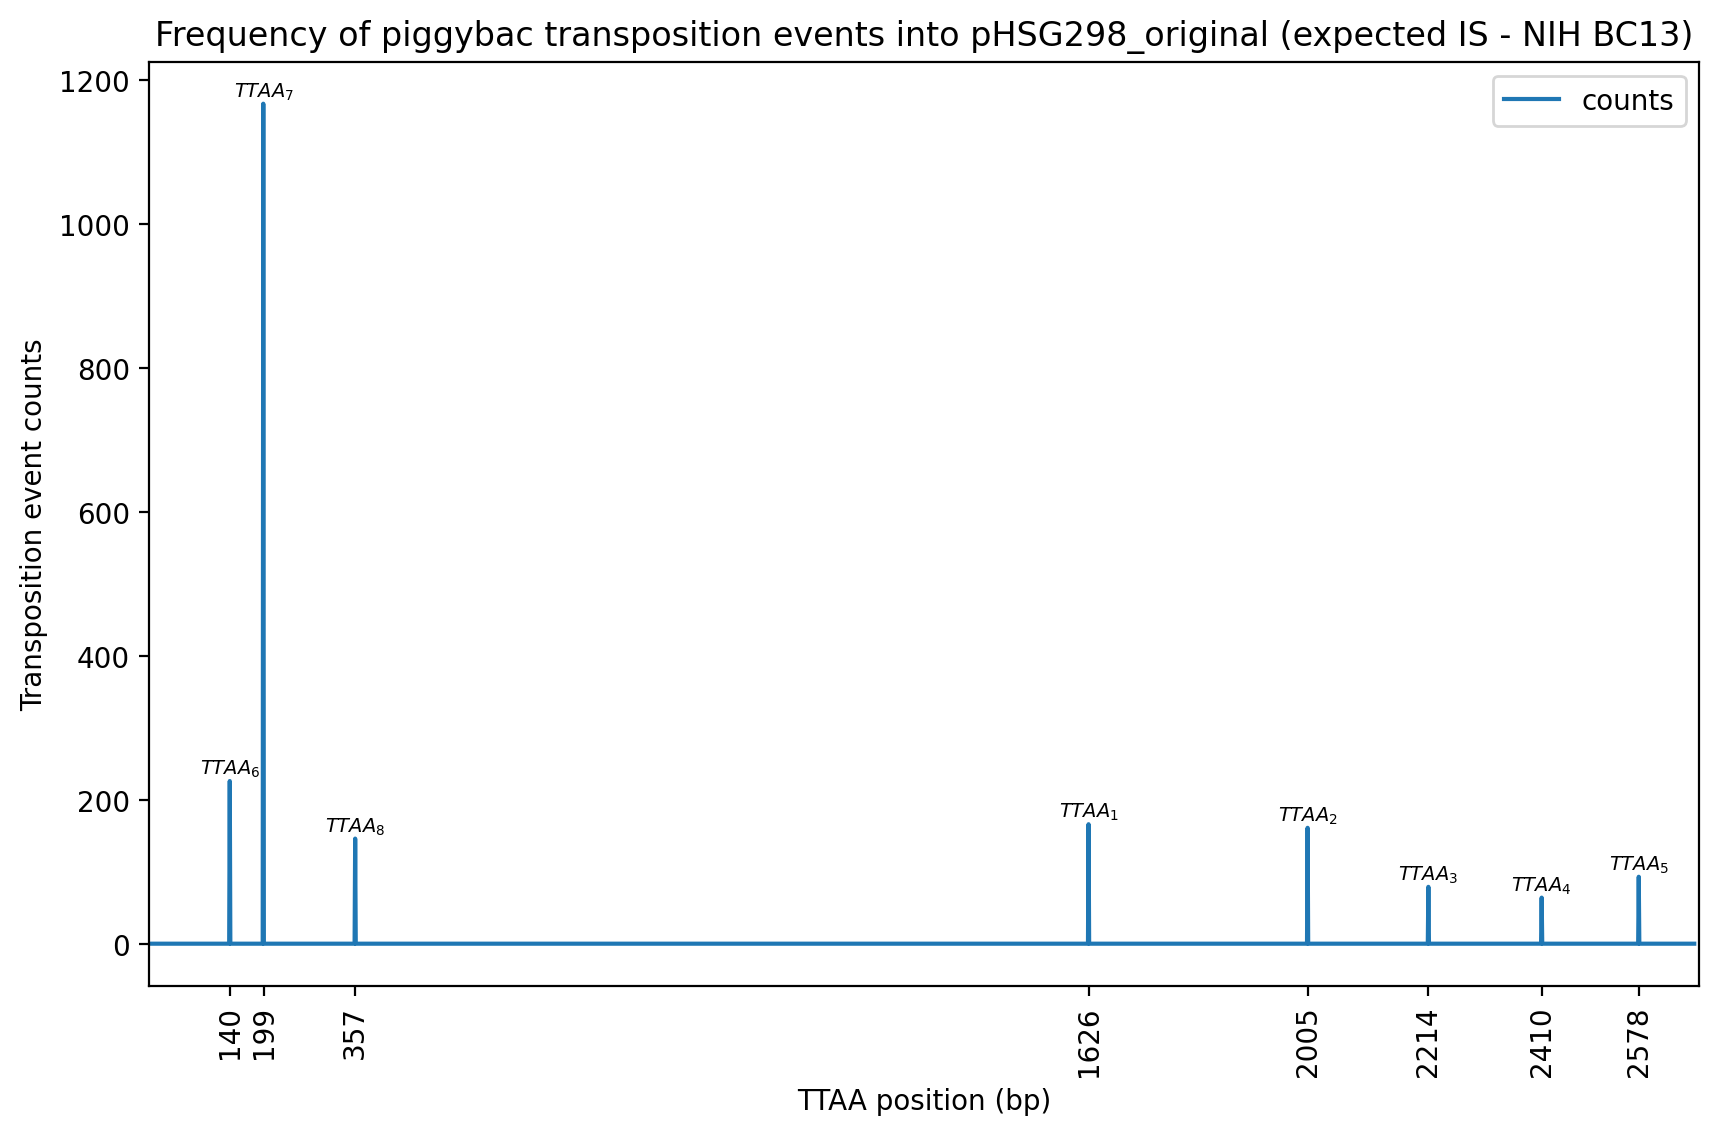

In [17]:
IS=[140,199,357,1626,2005,2214,2410,2578]

p1 = my_freq_orig_expected_bc13.plot(x='coords_x', y='counts',
            xlabel='TTAA position (bp)', 
            ylabel='Transposition event counts', 
            xlim=(1,2683),
            xticks=(140,199,357,1626,2005,2214,2410,2578),
            rot=90
            )

p1.set_title('Frequency of piggybac transposition events into pHSG298_original (expected IS - NIH BC13)')
p1.text(IS[0], my_freq_orig_expected_bc13.iloc[IS[0]-10:IS[0]+10]['counts'].max() + 10, "$TTAA_6$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[1], my_freq_orig_expected_bc13.iloc[IS[1]-10:IS[1]+10]['counts'].max() + 10, "$TTAA_7$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[2], my_freq_orig_expected_bc13.iloc[IS[2]-10:IS[2]+10]['counts'].max() + 10, "$TTAA_8$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[3], my_freq_orig_expected_bc13.iloc[IS[3]-10:IS[3]+10]['counts'].max() + 10, "$TTAA_1$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[4], my_freq_orig_expected_bc13.iloc[IS[4]-10:IS[4]+10]['counts'].max() + 10, "$TTAA_2$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[5], my_freq_orig_expected_bc13.iloc[IS[5]-10:IS[5]+10]['counts'].max() + 10, "$TTAA_3$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[6], my_freq_orig_expected_bc13.iloc[IS[6]-10:IS[6]+10]['counts'].max() + 10, "$TTAA_4$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[7], my_freq_orig_expected_bc13.iloc[IS[7]-10:IS[7]+10]['counts'].max() + 10, "$TTAA_5$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')

plt.show(p1)

fig = p1.get_figure()
fig.savefig('bc13_vs_original_expected.pdf')

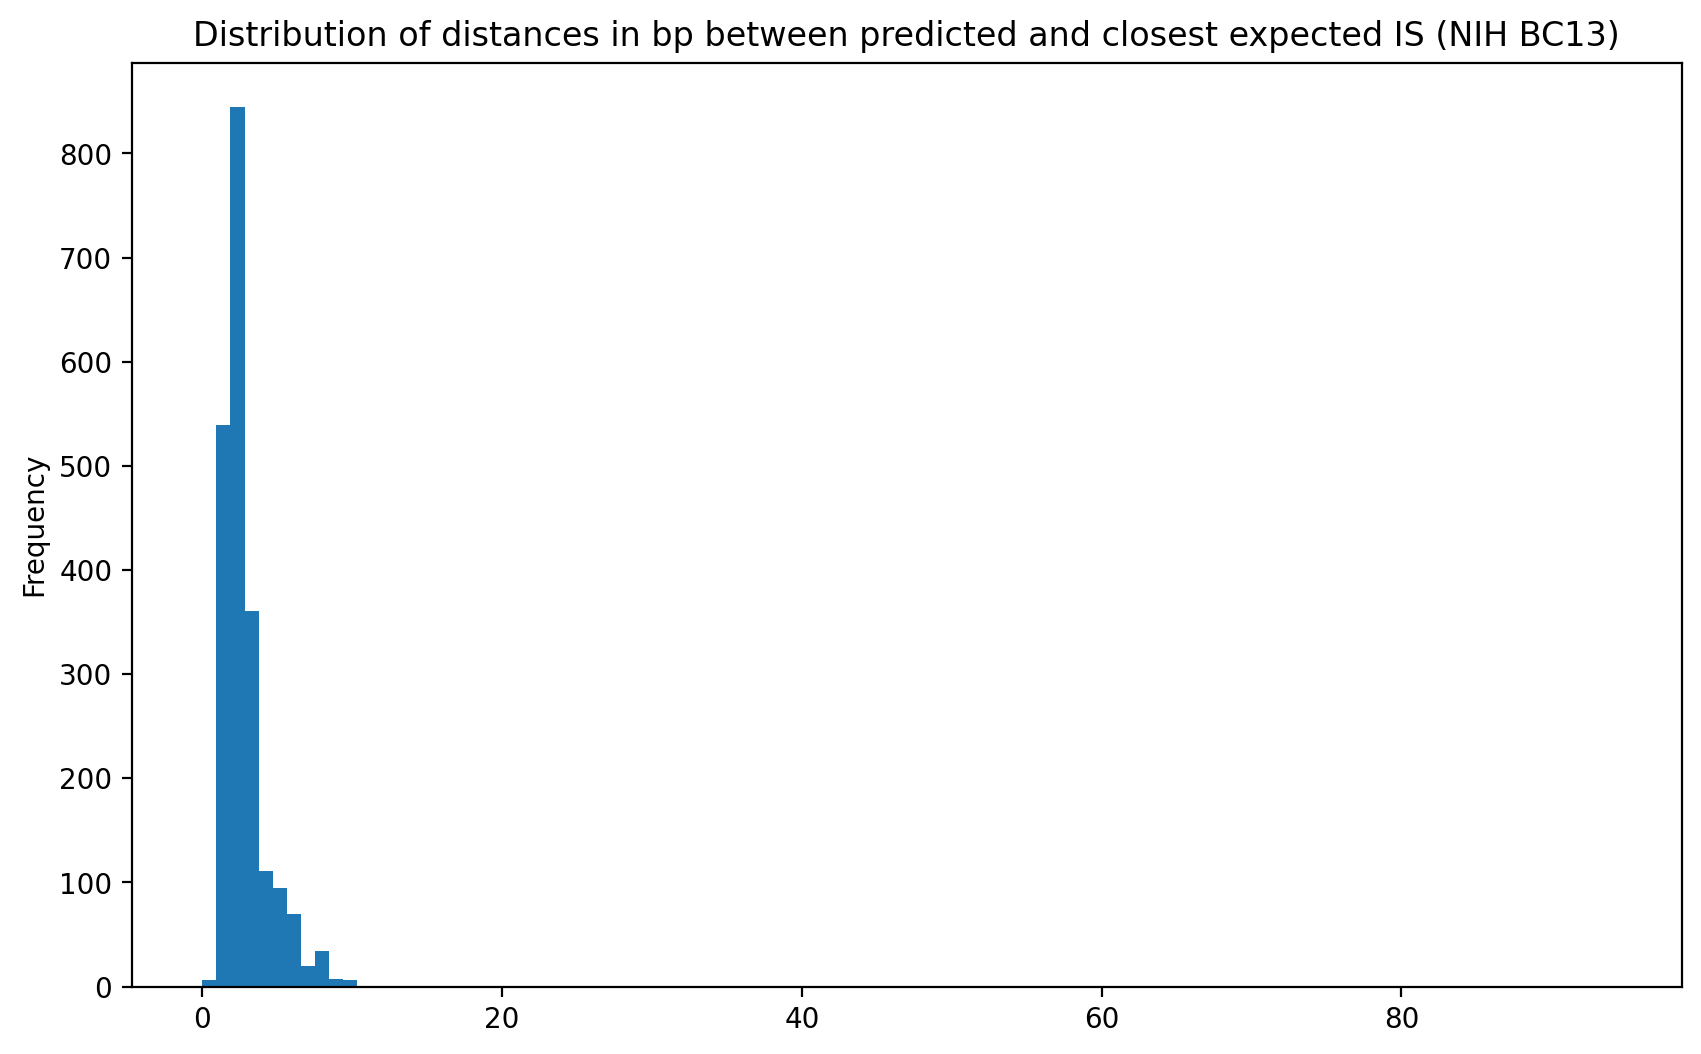

In [18]:
p1_hist = is_results_orig_bc13['dist_p_e'].plot(kind='hist', bins=100,
                                title='Distribution of distances in bp between predicted and closest expected IS (NIH BC13)',
                                xlabel='Predicted vs expected IS distance (bp)'
                            )
plt.show(p1_hist)

## Load NIH dataset BC37 (modified)

In [19]:
# Load blastn result
my_blastn_file = './SINGLE_END/BC37_trimmed.filter.hits.flanking_vs_modified.NR.bn'
my_bed_file = './SINGLE_END/BC37_trimmed.filter.hits.bed'

df_orig_bc37 = upload_blastn_tab_file(blastn_file=my_blastn_file)
df_bed_bc37 = pd.read_csv(my_bed_file, sep='\t', header=None, names=['read_id','end_5','end_3','is_coord'])

# Remove reads with unique blastn hits
#df_orig_dupl = remove_duplicates(df_orig)


# Identify IS sites
is_results_orig_bc37 = quantify_IS_sites(blastn_df=df_orig_bc37, 
                                    plasmid_name='modified', 
                                    my_bed_df=df_bed_bc37
                                    )

# Calculate IS frequency
my_freq_orig_bc37 = calculate_is_frequency(is_results_orig_bc37,'modified')
my_freq_orig_expected_bc37 = calculate_is_frequency_by_expected(is_results_orig_bc37,'modified')

Counting IS sites:   0%|          | 0/35917 [00:00<?, ?it/s]

## Make IS frequency plot

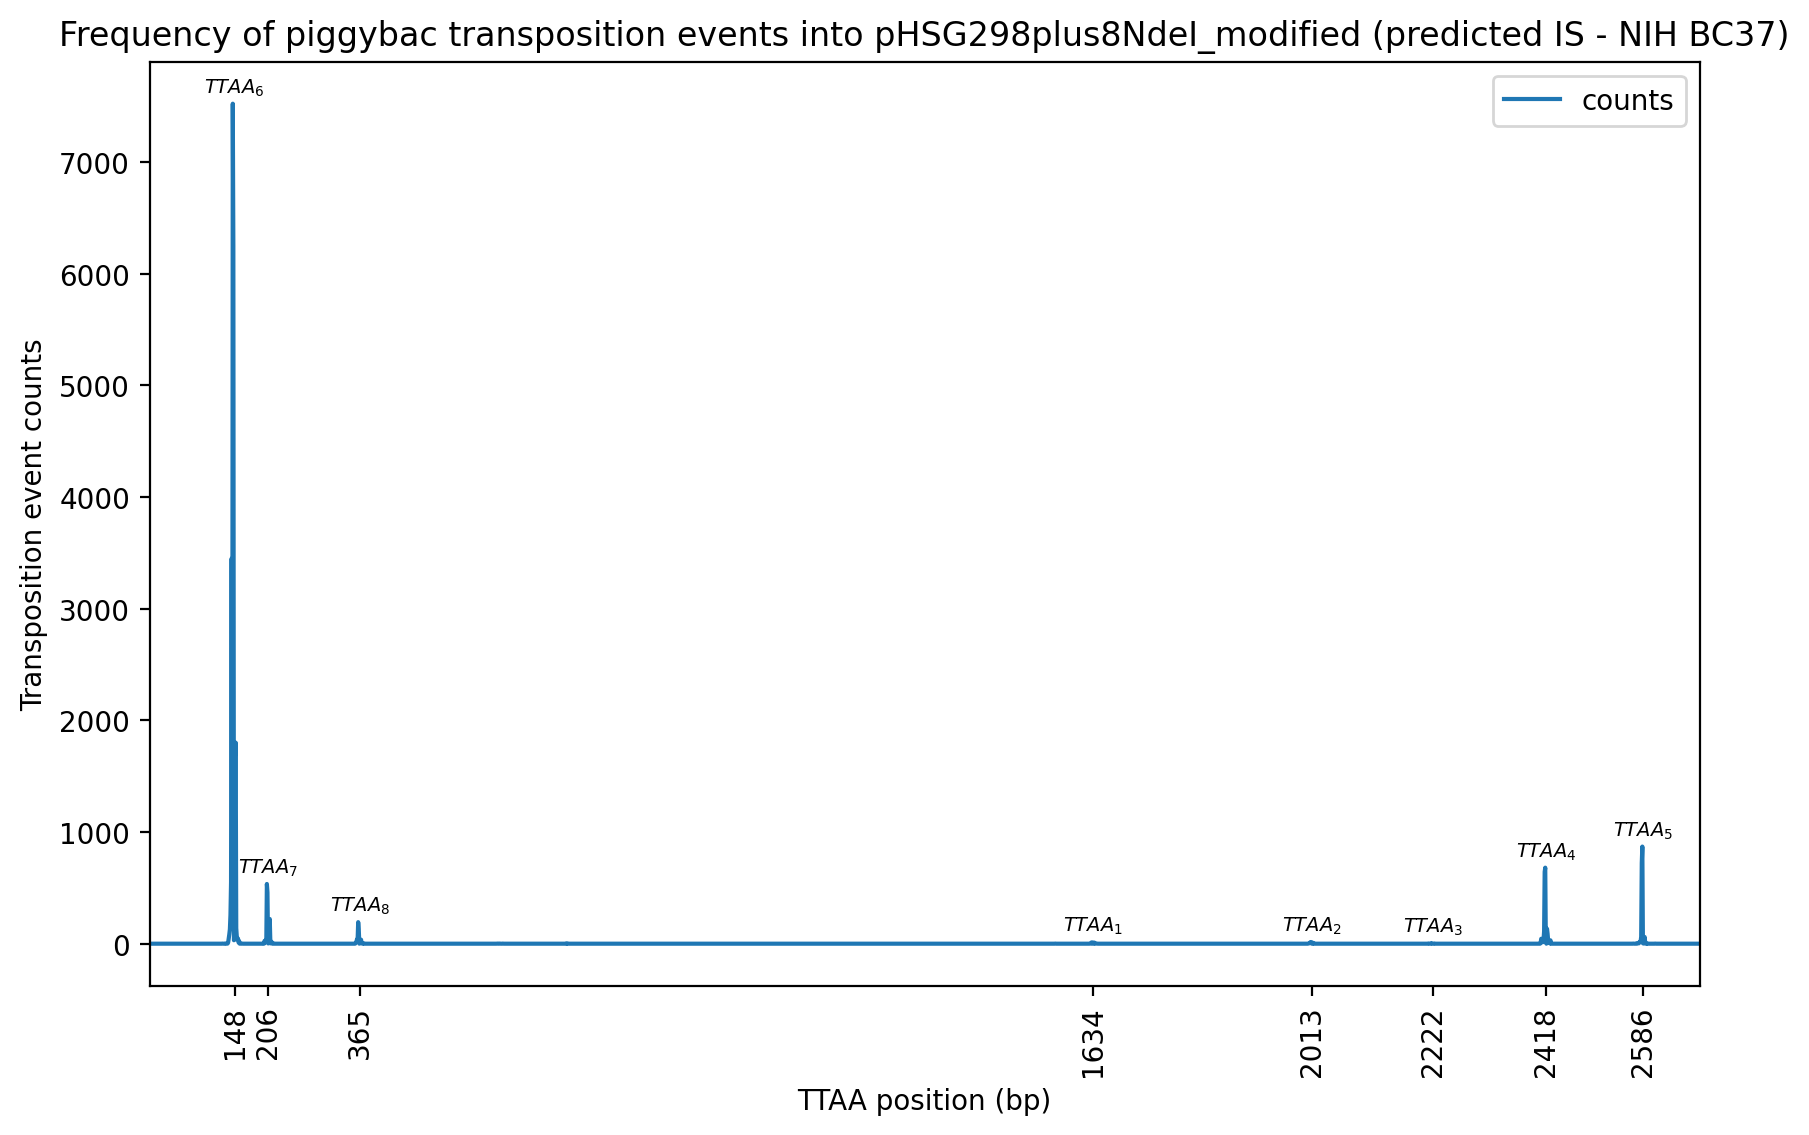

In [20]:
IS=[148,206,365,1634,2013,2222,2418,2586]

p1 = my_freq_orig_bc37.plot(x='coords_x', y='counts',
            xlabel='TTAA position (bp)', 
            ylabel='Transposition event counts', 
            xlim=(1,2683),
            xticks=(148,206,365,1634,2013,2222,2418,2586),
            rot=90
            )

p1.set_title('Frequency of piggybac transposition events into pHSG298plus8NdeI_modified (predicted IS - NIH BC37)')
p1.text(IS[0], my_freq_orig_bc37.iloc[IS[0]-10:IS[0]+10]['counts'].max() + 100, "$TTAA_6$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[1], my_freq_orig_bc37.iloc[IS[1]-10:IS[1]+10]['counts'].max() + 100, "$TTAA_7$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[2], my_freq_orig_bc37.iloc[IS[2]-10:IS[2]+10]['counts'].max() + 100, "$TTAA_8$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[3], my_freq_orig_bc37.iloc[IS[3]-10:IS[3]+10]['counts'].max() + 100, "$TTAA_1$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[4], my_freq_orig_bc37.iloc[IS[4]-10:IS[4]+10]['counts'].max() + 100, "$TTAA_2$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[5], my_freq_orig_bc37.iloc[IS[5]-10:IS[5]+10]['counts'].max() + 100, "$TTAA_3$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[6], my_freq_orig_bc37.iloc[IS[6]-10:IS[6]+10]['counts'].max() + 100, "$TTAA_4$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[7], my_freq_orig_bc37.iloc[IS[7]-10:IS[7]+10]['counts'].max() + 100, "$TTAA_5$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')

plt.show(p1)

fig = p1.get_figure()
fig.savefig('bc37_vs_original_predicted.pdf')

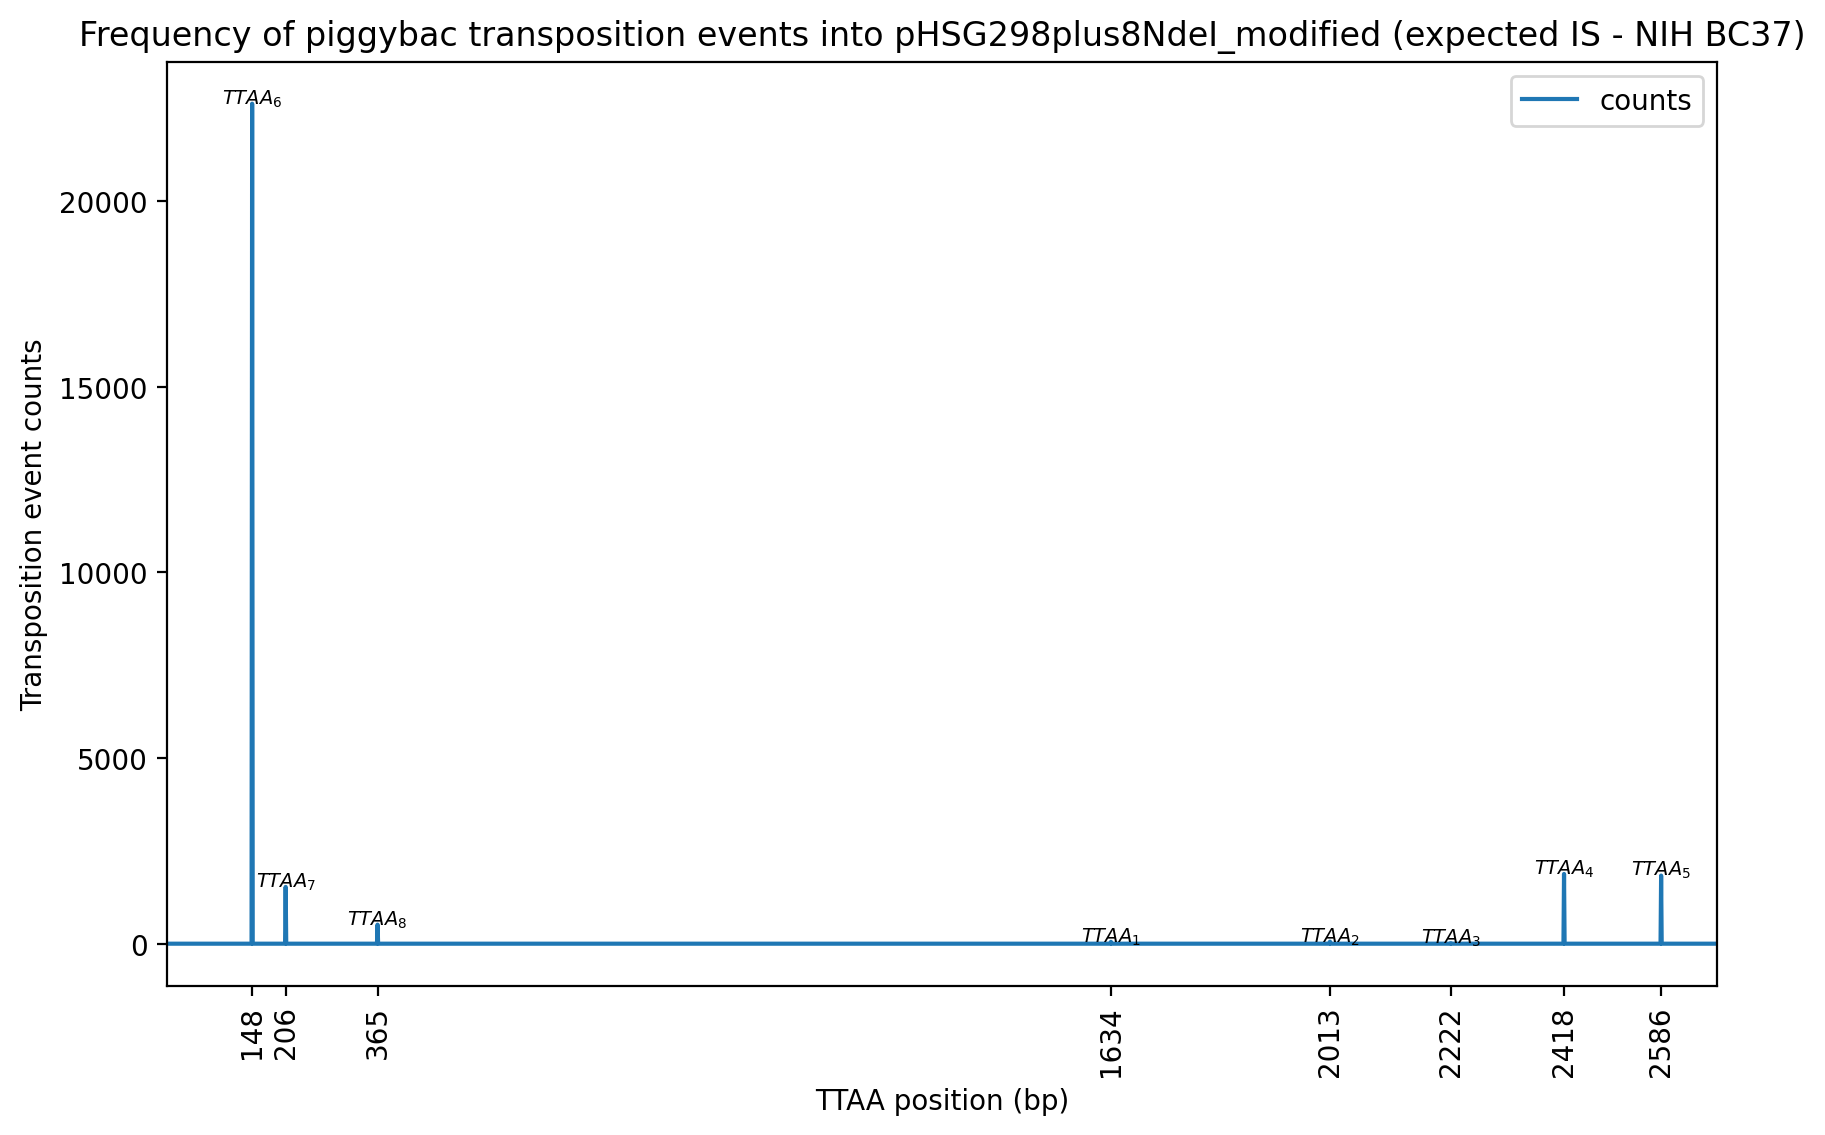

In [21]:
IS=[148,206,365,1634,2013,2222,2418,2586]

p1 = my_freq_orig_expected_bc37.plot(x='coords_x', y='counts',
            xlabel='TTAA position (bp)', 
            ylabel='Transposition event counts', 
            xlim=(1,2683),
            xticks=(148,206,365,1634,2013,2222,2418,2586),
            rot=90
            )

p1.set_title('Frequency of piggybac transposition events into pHSG298plus8NdeI_modified (expected IS - NIH BC37)')
p1.text(IS[0], my_freq_orig_expected_bc37.iloc[IS[0]-10:IS[0]+10]['counts'].max() + 10, "$TTAA_6$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[1], my_freq_orig_expected_bc37.iloc[IS[1]-10:IS[1]+10]['counts'].max() + 10, "$TTAA_7$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[2], my_freq_orig_expected_bc37.iloc[IS[2]-10:IS[2]+10]['counts'].max() + 10, "$TTAA_8$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[3], my_freq_orig_expected_bc37.iloc[IS[3]-10:IS[3]+10]['counts'].max() + 10, "$TTAA_1$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[4], my_freq_orig_expected_bc37.iloc[IS[4]-10:IS[4]+10]['counts'].max() + 10, "$TTAA_2$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[5], my_freq_orig_expected_bc37.iloc[IS[5]-10:IS[5]+10]['counts'].max() + 10, "$TTAA_3$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[6], my_freq_orig_expected_bc37.iloc[IS[6]-10:IS[6]+10]['counts'].max() + 10, "$TTAA_4$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[7], my_freq_orig_expected_bc37.iloc[IS[7]-10:IS[7]+10]['counts'].max() + 10, "$TTAA_5$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')

plt.show(p1)

fig = p1.get_figure()
fig.savefig('bc37_vs_original_expected.pdf')

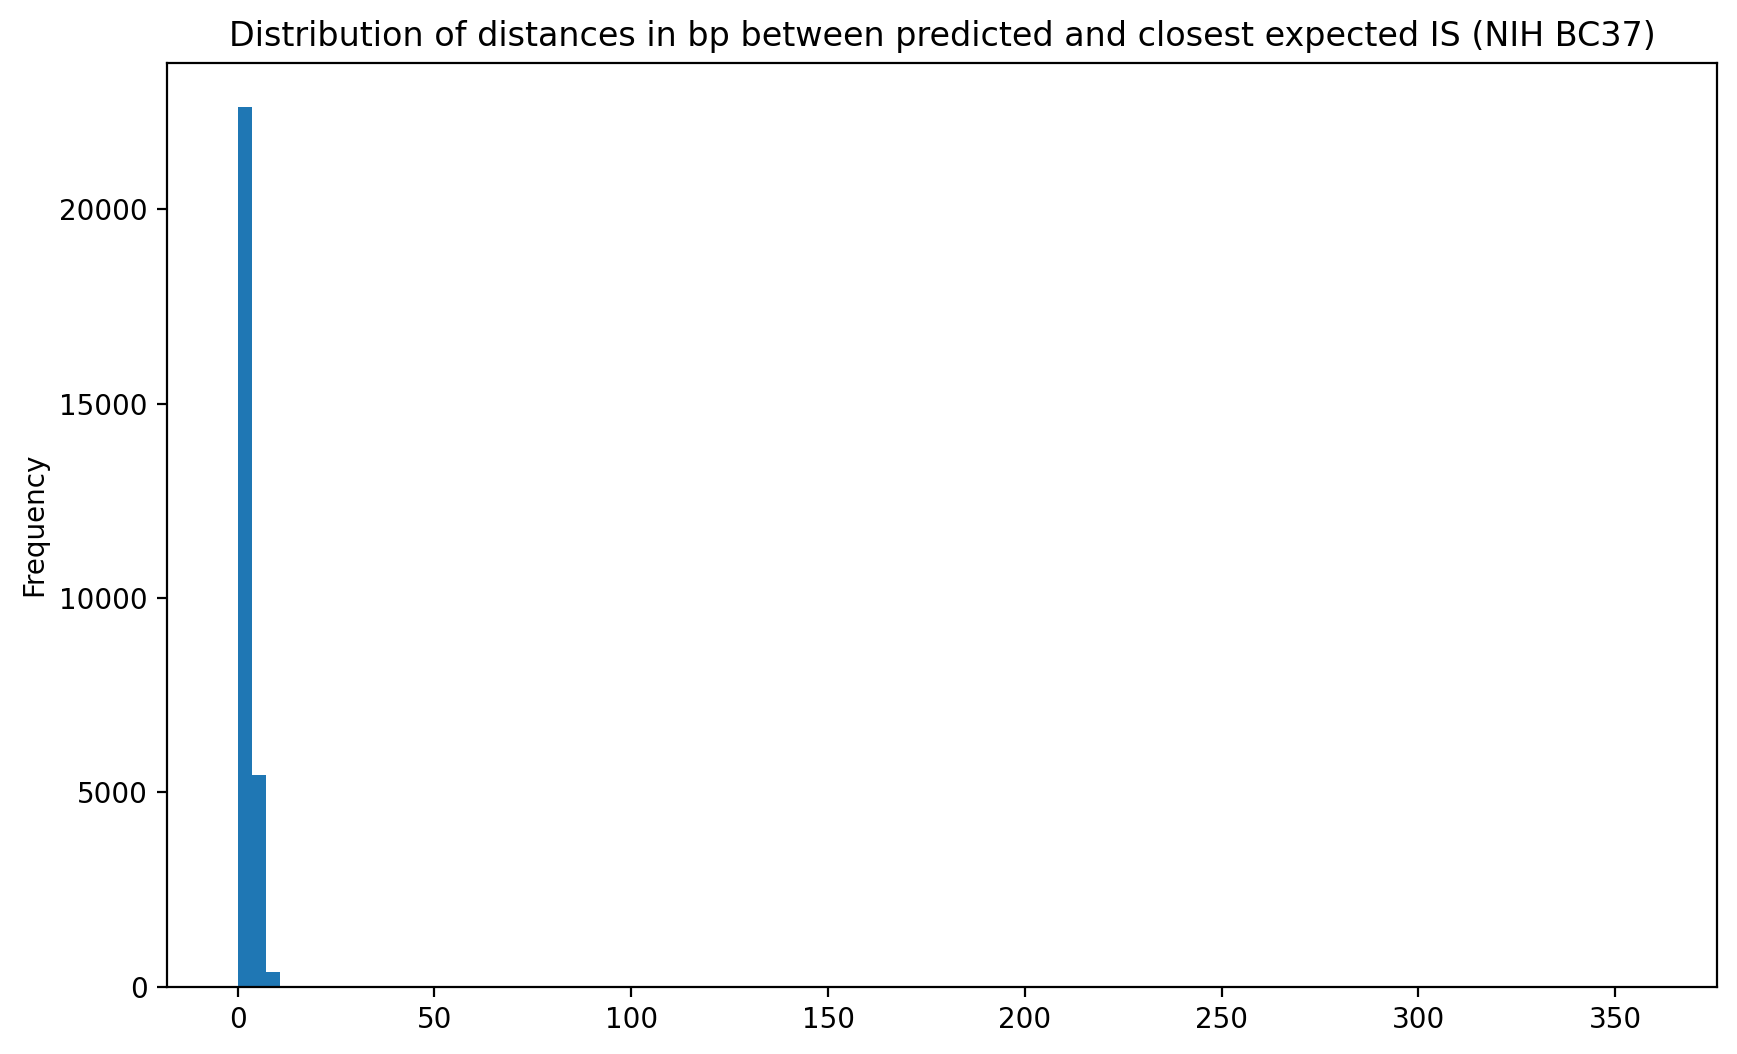

In [22]:
p1_hist = is_results_orig_bc37['dist_p_e'].plot(kind='hist', bins=100,
                                title='Distribution of distances in bp between predicted and closest expected IS (NIH BC37)',
                                xlabel='Predicted vs expected IS distance (bp)'
                            )
plt.show(p1_hist)

## Load NIH dataset BC25 (modified)

In [23]:
# Load blastn result
my_blastn_file = './SINGLE_END/BC25_trimmed.filter.hits.flanking_vs_modified.NR.bn'
my_bed_file = './SINGLE_END/BC25_trimmed.filter.hits.bed'

df_orig_bc25 = upload_blastn_tab_file(blastn_file=my_blastn_file)
df_bed_bc25 = pd.read_csv(my_bed_file, sep='\t', header=None, names=['read_id','end_5','end_3','is_coord'])

# Remove reads with unique blastn hits
#df_orig_dupl = remove_duplicates(df_orig)


# Identify IS sites
is_results_orig_bc25 = quantify_IS_sites(blastn_df=df_orig_bc25, 
                                    plasmid_name='modified', 
                                    my_bed_df=df_bed_bc25
                                    )

# Calculate IS frequency
my_freq_orig_bc25 = calculate_is_frequency(is_results_orig_bc25,'modified')
my_freq_orig_expected_bc25 = calculate_is_frequency_by_expected(is_results_orig_bc25,'modified')

Counting IS sites:   0%|          | 0/39809 [00:00<?, ?it/s]

## Make IS frequency plot

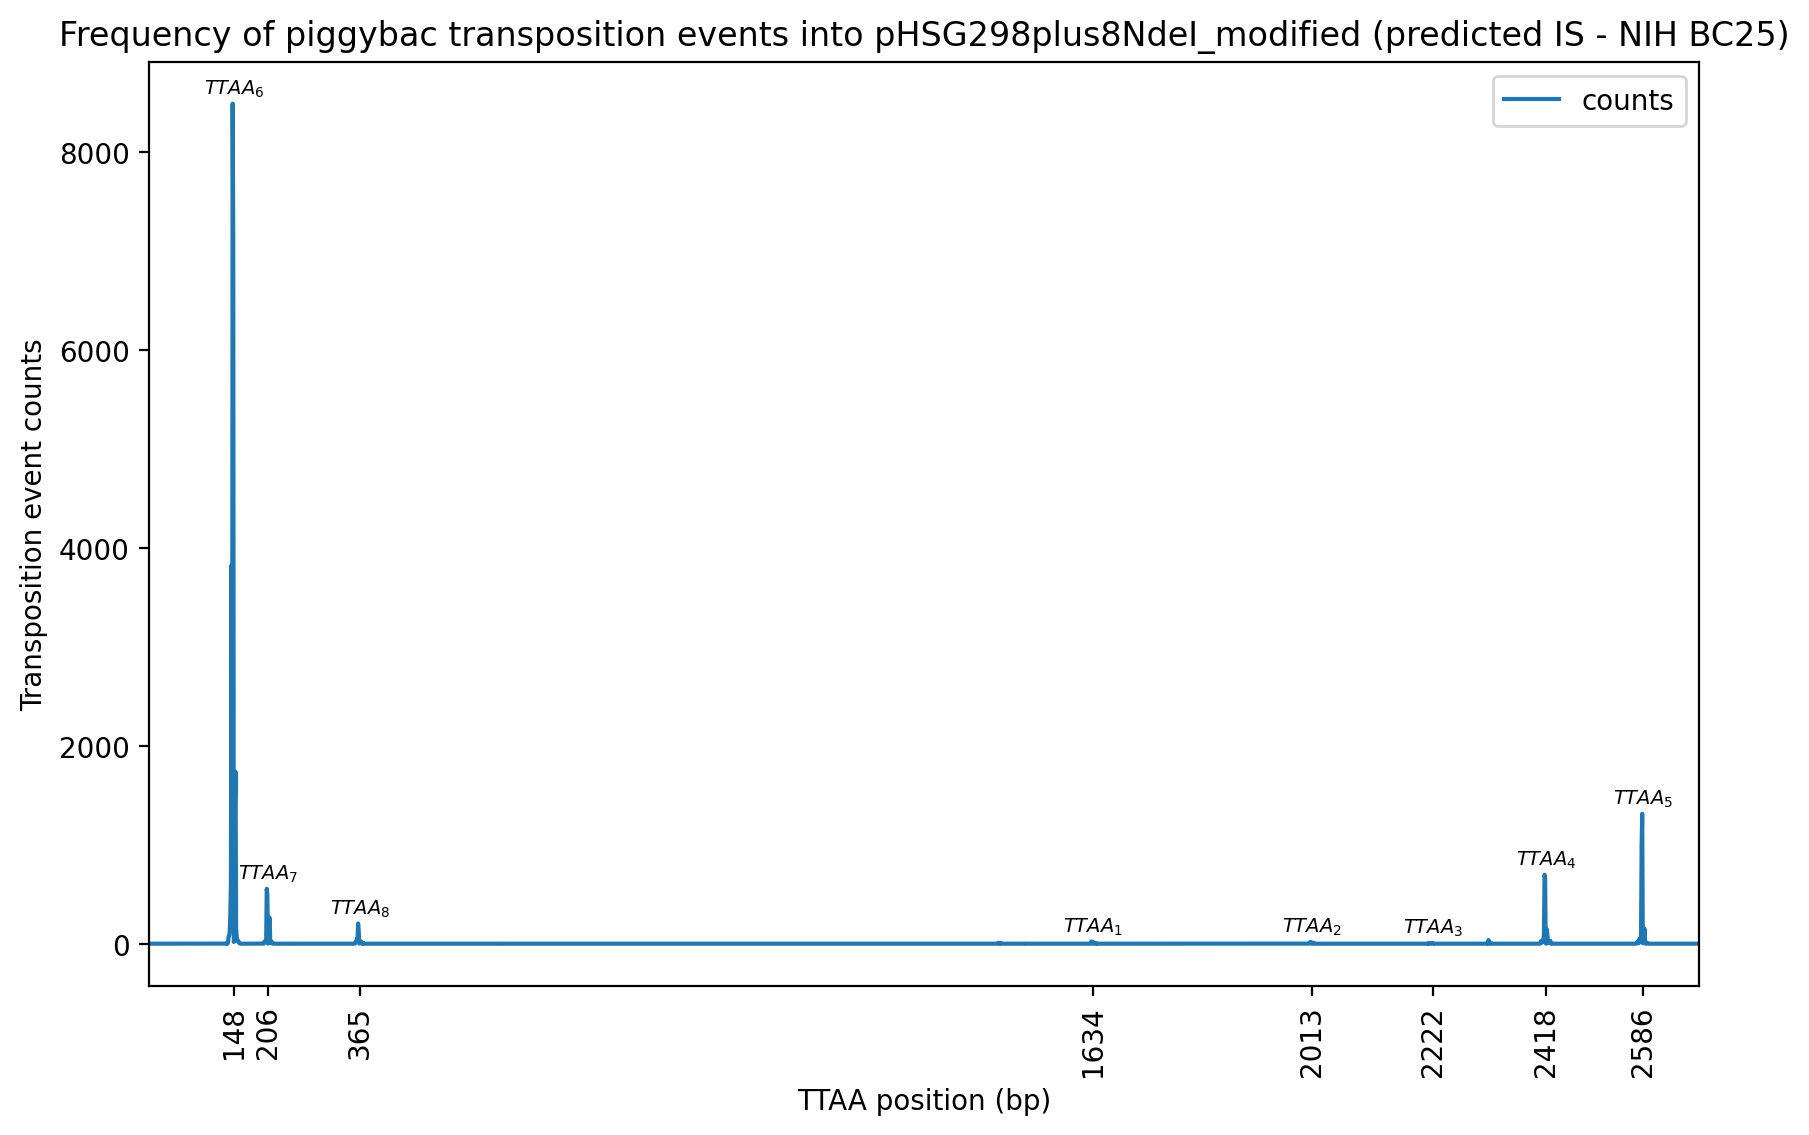

In [24]:
IS=[148,206,365,1634,2013,2222,2418,2586]

p1 = my_freq_orig_bc25.plot(x='coords_x', y='counts',
            xlabel='TTAA position (bp)', 
            ylabel='Transposition event counts', 
            xlim=(1,2683),
            xticks=(148,206,365,1634,2013,2222,2418,2586),
            rot=90
            )

p1.set_title('Frequency of piggybac transposition events into pHSG298plus8NdeI_modified (predicted IS - NIH BC25)')
p1.text(IS[0], my_freq_orig_bc25.iloc[IS[0]-10:IS[0]+10]['counts'].max() + 100, "$TTAA_6$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[1], my_freq_orig_bc25.iloc[IS[1]-10:IS[1]+10]['counts'].max() + 100, "$TTAA_7$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[2], my_freq_orig_bc25.iloc[IS[2]-10:IS[2]+10]['counts'].max() + 100, "$TTAA_8$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[3], my_freq_orig_bc25.iloc[IS[3]-10:IS[3]+10]['counts'].max() + 100, "$TTAA_1$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[4], my_freq_orig_bc25.iloc[IS[4]-10:IS[4]+10]['counts'].max() + 100, "$TTAA_2$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[5], my_freq_orig_bc25.iloc[IS[5]-10:IS[5]+10]['counts'].max() + 100, "$TTAA_3$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[6], my_freq_orig_bc25.iloc[IS[6]-10:IS[6]+10]['counts'].max() + 100, "$TTAA_4$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[7], my_freq_orig_bc25.iloc[IS[7]-10:IS[7]+10]['counts'].max() + 100, "$TTAA_5$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')

plt.show(p1)

fig = p1.get_figure()
fig.savefig('bc25_vs_original_predicted.pdf')

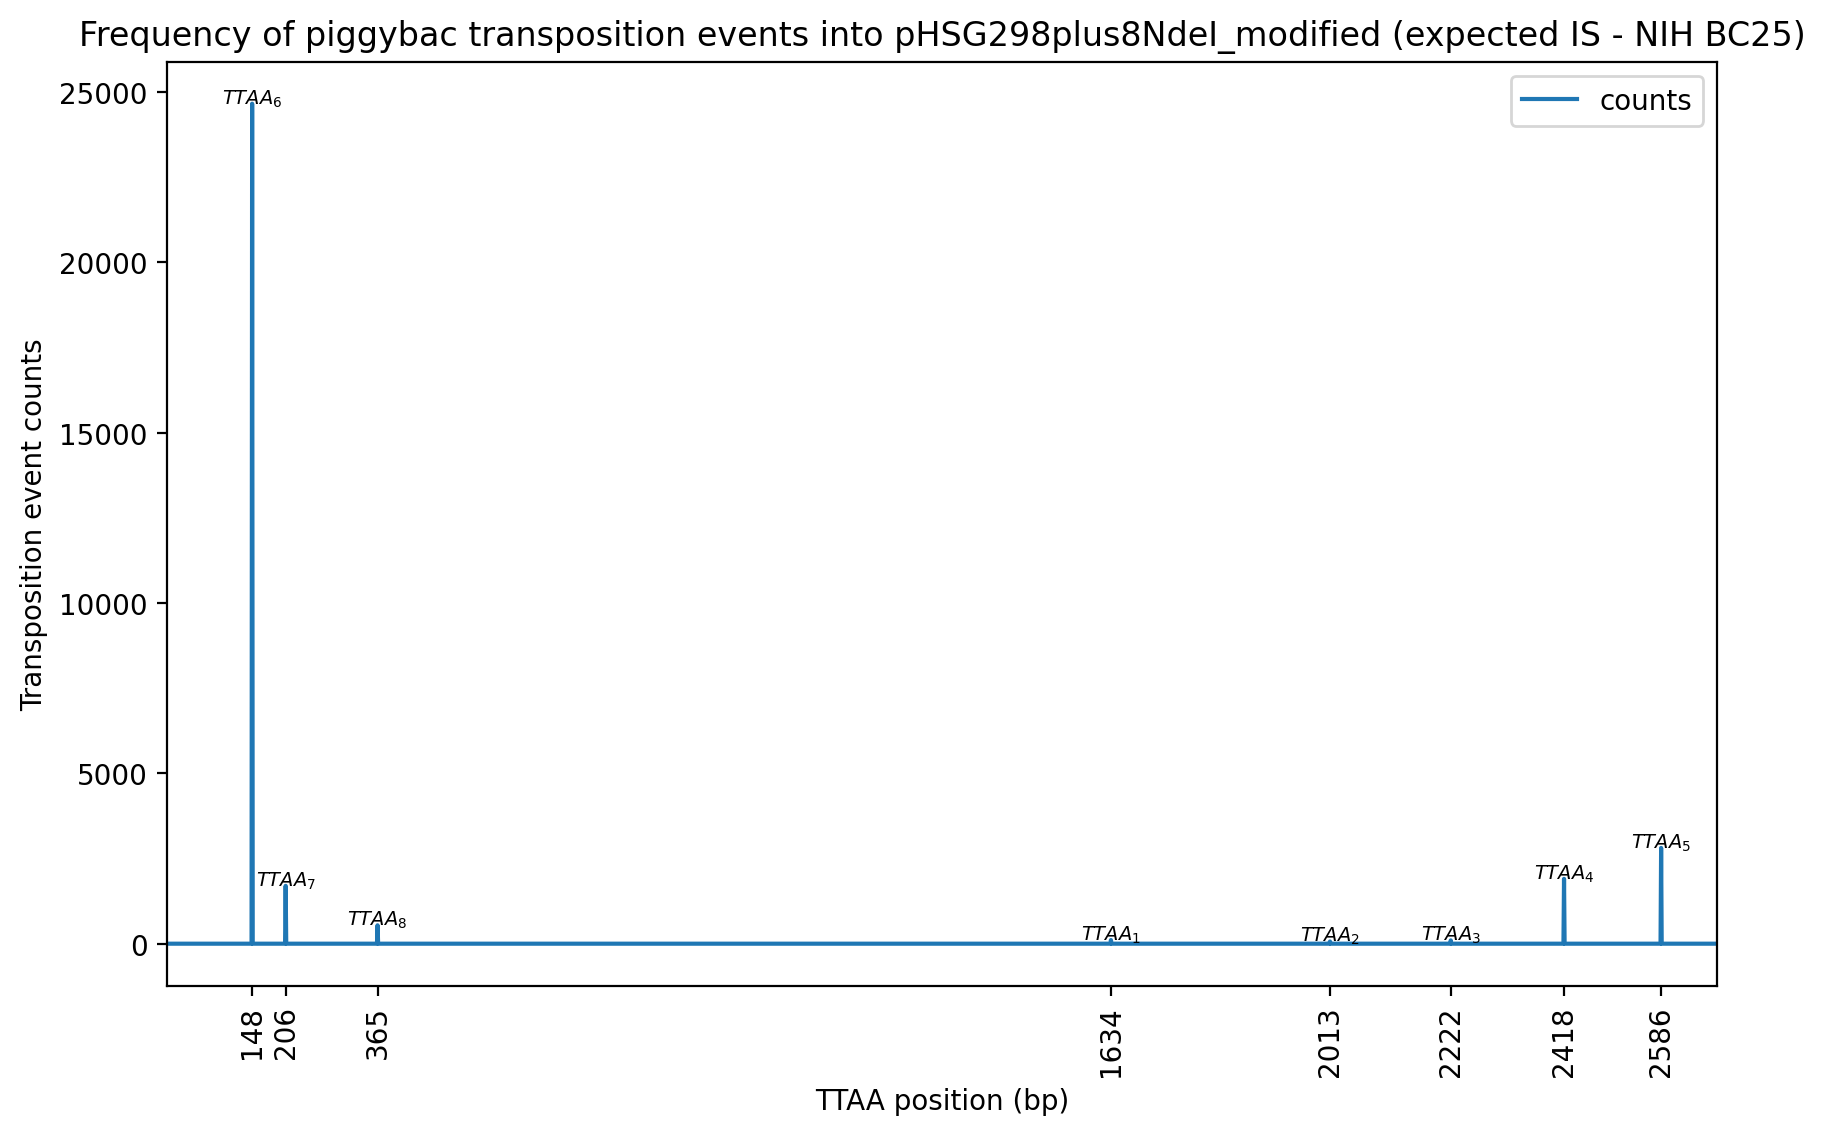

In [25]:
IS=[148,206,365,1634,2013,2222,2418,2586]

p1 = my_freq_orig_expected_bc25.plot(x='coords_x', y='counts',
            xlabel='TTAA position (bp)', 
            ylabel='Transposition event counts', 
            xlim=(1,2683),
            xticks=(148,206,365,1634,2013,2222,2418,2586),
            rot=90
            )

p1.set_title('Frequency of piggybac transposition events into pHSG298plus8NdeI_modified (expected IS - NIH BC25)')
p1.text(IS[0], my_freq_orig_expected_bc25.iloc[IS[0]-10:IS[0]+10]['counts'].max() + 10, "$TTAA_6$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[1], my_freq_orig_expected_bc25.iloc[IS[1]-10:IS[1]+10]['counts'].max() + 10, "$TTAA_7$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[2], my_freq_orig_expected_bc25.iloc[IS[2]-10:IS[2]+10]['counts'].max() + 10, "$TTAA_8$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[3], my_freq_orig_expected_bc25.iloc[IS[3]-10:IS[3]+10]['counts'].max() + 10, "$TTAA_1$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[4], my_freq_orig_expected_bc25.iloc[IS[4]-10:IS[4]+10]['counts'].max() + 10, "$TTAA_2$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[5], my_freq_orig_expected_bc25.iloc[IS[5]-10:IS[5]+10]['counts'].max() + 10, "$TTAA_3$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[6], my_freq_orig_expected_bc25.iloc[IS[6]-10:IS[6]+10]['counts'].max() + 10, "$TTAA_4$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[7], my_freq_orig_expected_bc25.iloc[IS[7]-10:IS[7]+10]['counts'].max() + 10, "$TTAA_5$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')

plt.show(p1)

fig = p1.get_figure()
fig.savefig('bc25_vs_original_expected.pdf')

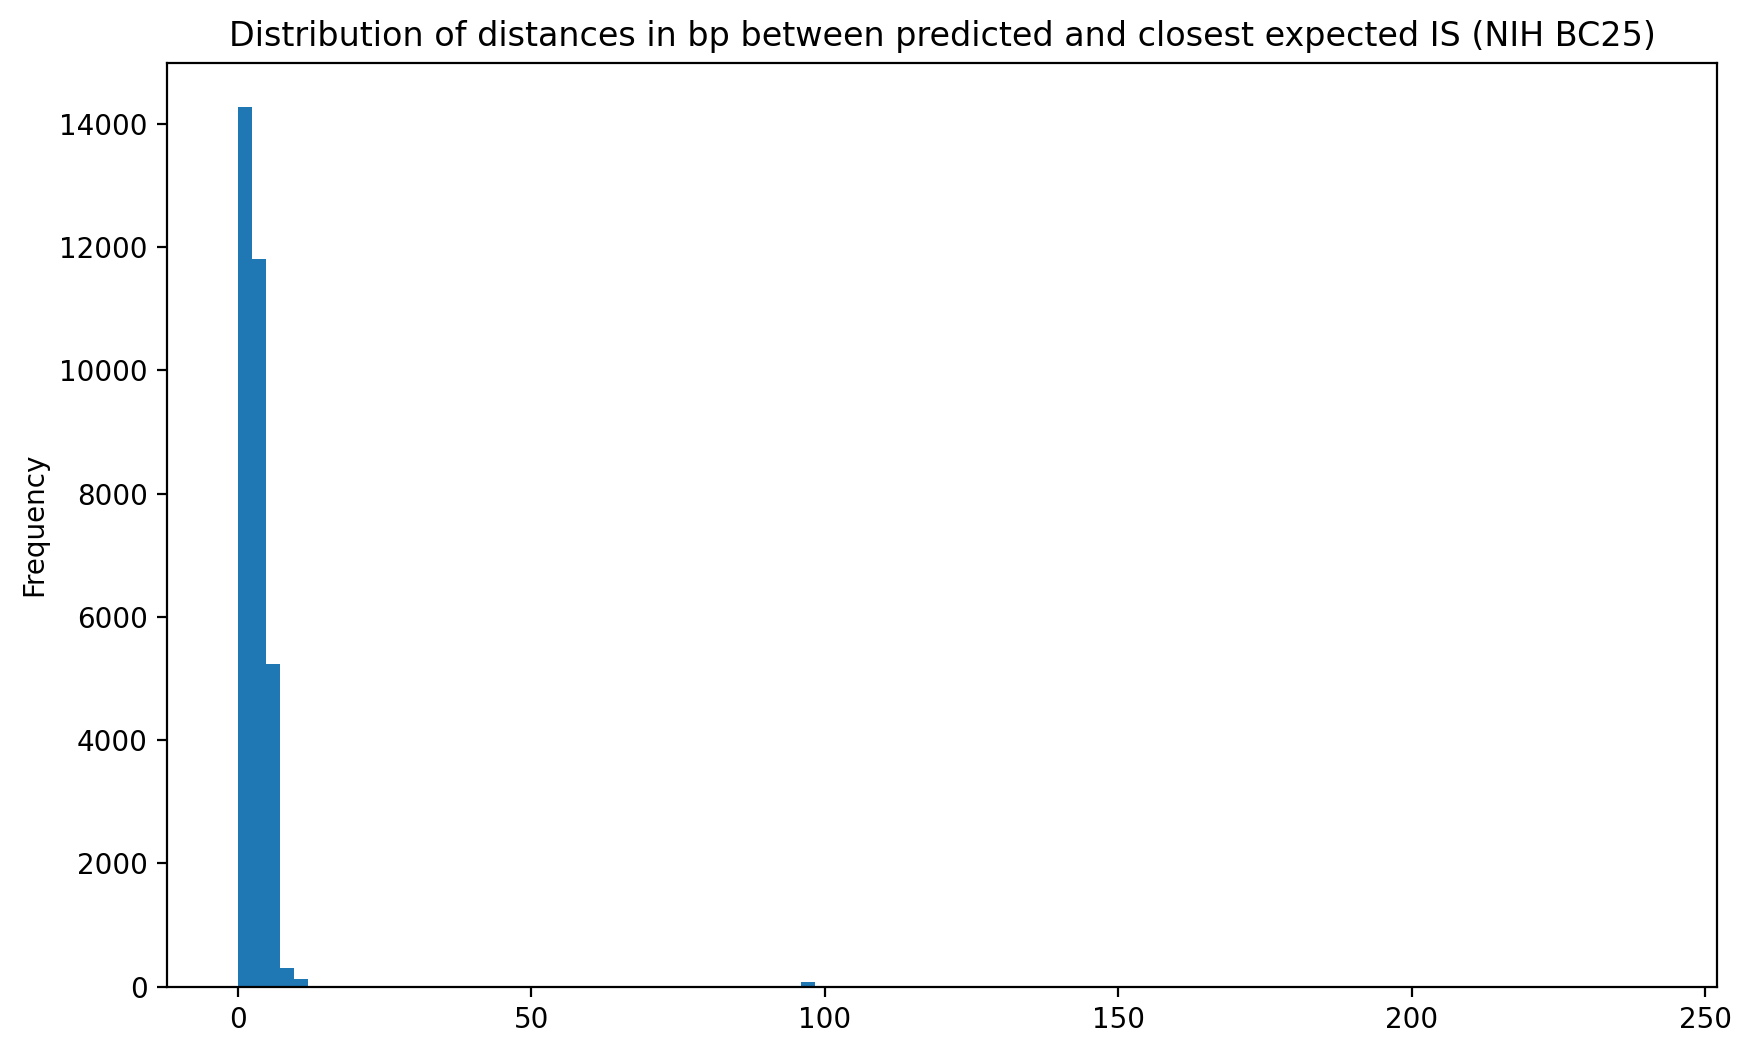

In [26]:
p1_hist = is_results_orig_bc25['dist_p_e'].plot(kind='hist', bins=100,
                                title='Distribution of distances in bp between predicted and closest expected IS (NIH BC25)',
                                xlabel='Predicted vs expected IS distance (bp)'
                            )
plt.show(p1_hist)

## Load plasmidsaurus modified Hickman_n2n_3_1A71  original dataset

In [27]:
# Load blastn result
my_blastn_file = './PLASMIDSAURUS/Hickman_n2n_3_1A71_trimmed.filter.hits.flanking_vs_original.NR.bn'
my_bed_file = './PLASMIDSAURUS/Hickman_n2n_3_1A71_trimmed.filter.hits.bed'

df_orig_hick_3 = upload_blastn_tab_file(blastn_file=my_blastn_file)
df_bed_hick_3 = pd.read_csv(my_bed_file, sep='\t', header=None, names=['read_id','end_5','end_3','is_coord'])

# Remove reads with unique blastn hits
#df_orig_dupl = remove_duplicates(df_orig)


# Identify IS sites
is_results_orig_hick_3 = quantify_IS_sites(blastn_df=df_orig_hick_3, 
                                    plasmid_name='original', 
                                    my_bed_df=df_bed_hick_3
                                    )

# Calculate IS frequency
my_freq_orig_hick_3 = calculate_is_frequency(is_results_orig_hick_3,'original')
my_freq_orig_expected_hick_3 = calculate_is_frequency_by_expected(is_results_orig_hick_3,'original')

Counting IS sites:   0%|          | 0/280 [00:00<?, ?it/s]

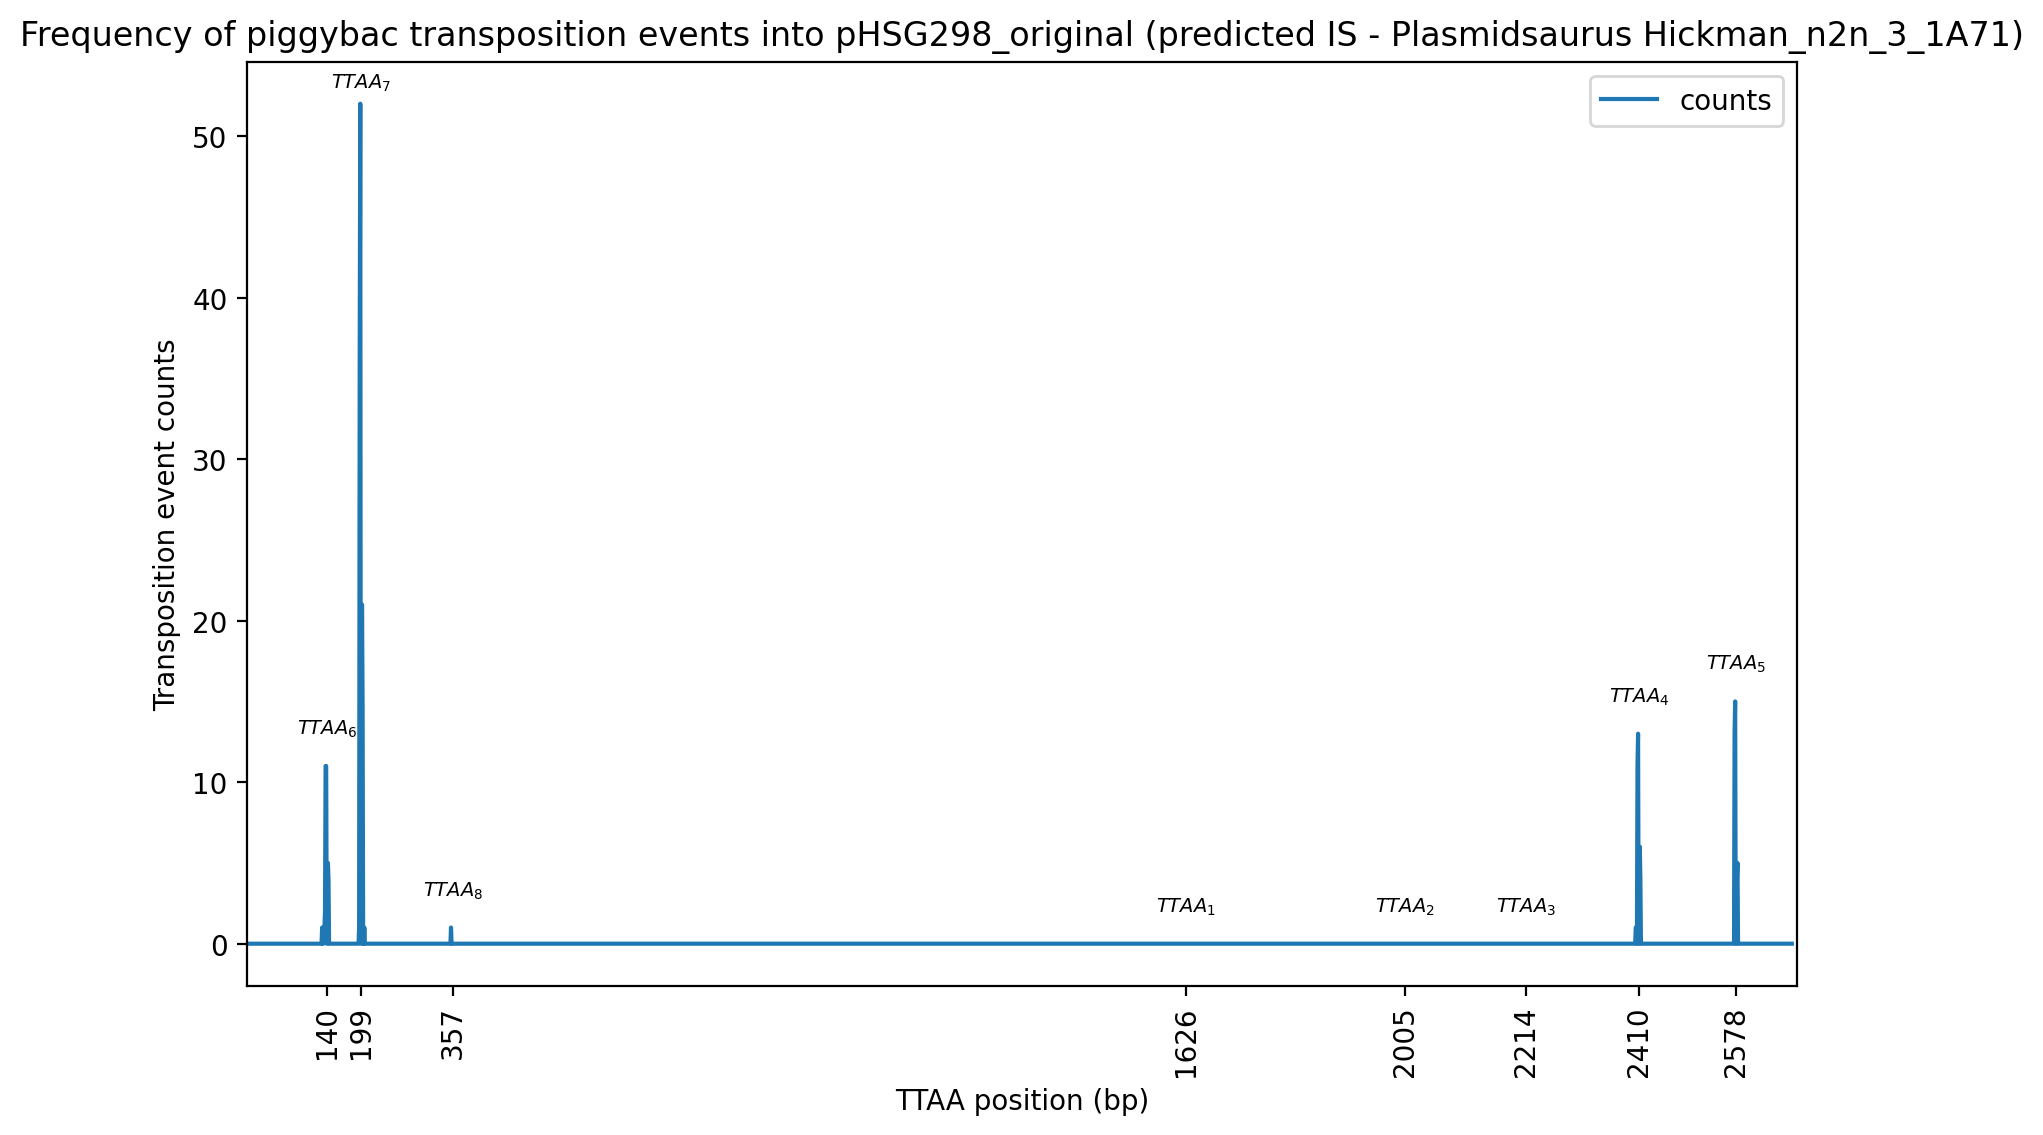

In [38]:
IS=[140,199,357,1626,2005,2214,2410,2578]

p1 = my_freq_orig_hick_3.plot(x='coords_x', y='counts',
            xlabel='TTAA position (bp)', 
            ylabel='Transposition event counts', 
            xlim=(1,2683),
            xticks=(140,199,357,1626,2005,2214,2410,2578),
            rot=90
            )

p1.set_title('Frequency of piggybac transposition events into pHSG298_original (predicted IS - Plasmidsaurus Hickman_n2n_3_1A71)')
p1.text(IS[0], my_freq_orig_hick_3.iloc[IS[0]-10:IS[0]+10]['counts'].max() + 2, "$TTAA_6$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[1], my_freq_orig_hick_3.iloc[IS[1]-10:IS[1]+10]['counts'].max() + 1, "$TTAA_7$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[2], my_freq_orig_hick_3.iloc[IS[2]-10:IS[2]+10]['counts'].max() + 2, "$TTAA_8$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[3], my_freq_orig_hick_3.iloc[IS[3]-10:IS[3]+10]['counts'].max() + 2, "$TTAA_1$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[4], my_freq_orig_hick_3.iloc[IS[4]-10:IS[4]+10]['counts'].max() + 2, "$TTAA_2$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[5], my_freq_orig_hick_3.iloc[IS[5]-10:IS[5]+10]['counts'].max() + 2, "$TTAA_3$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[6], my_freq_orig_hick_3.iloc[IS[6]-10:IS[6]+10]['counts'].max() + 2, "$TTAA_4$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[7], my_freq_orig_hick_3.iloc[IS[7]-10:IS[7]+10]['counts'].max() + 2, "$TTAA_5$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')

plt.show(p1)

fig = p1.get_figure()
fig.savefig('hick_3_vs_original_predicted.pdf')

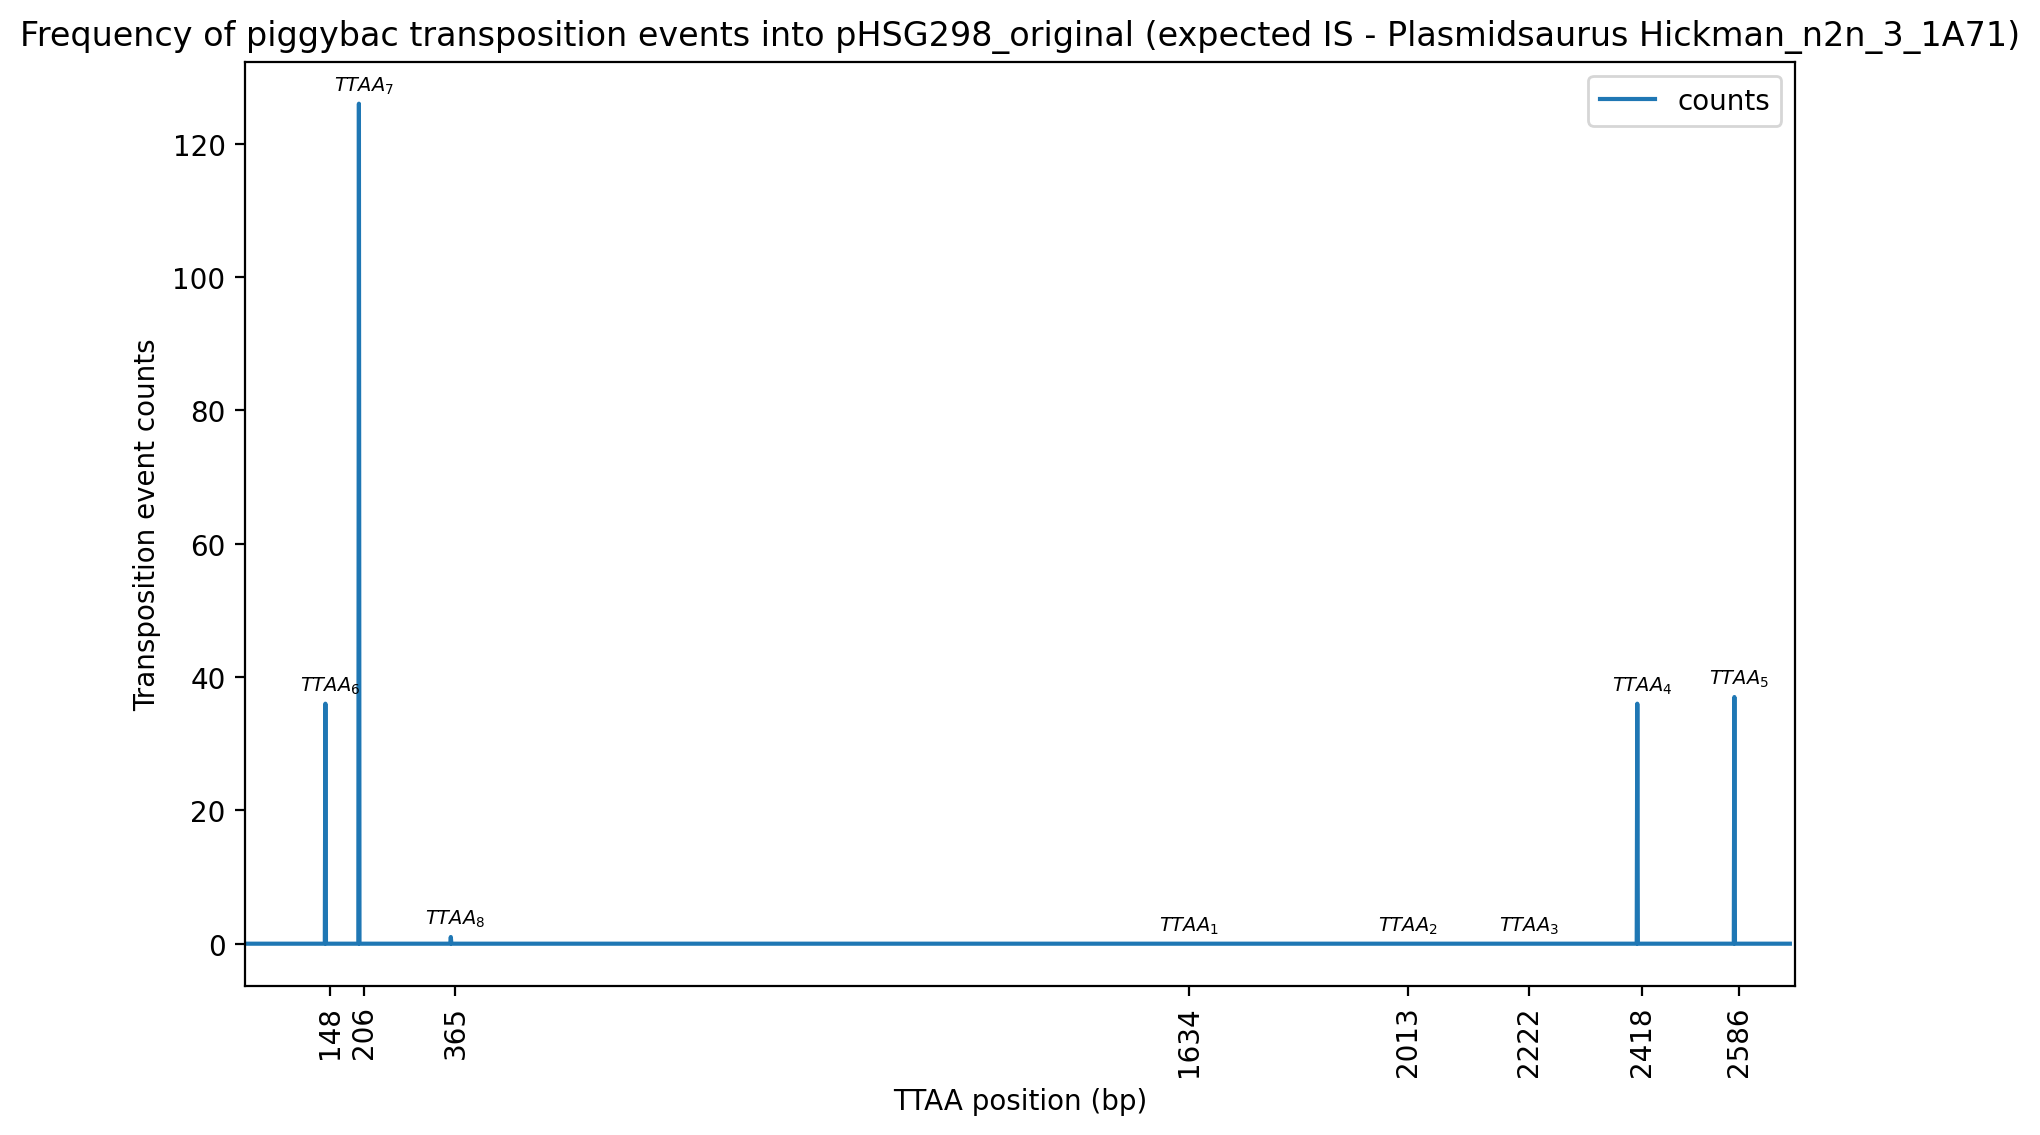

In [37]:
IS=[148,206,365,1634,2013,2222,2418,2586]

p1 = my_freq_orig_expected_hick_3.plot(x='coords_x', y='counts',
            xlabel='TTAA position (bp)', 
            ylabel='Transposition event counts', 
            xlim=(1,2683),
            xticks=(148,206,365,1634,2013,2222,2418,2586),
            rot=90
            )

p1.set_title('Frequency of piggybac transposition events into pHSG298_original (expected IS - Plasmidsaurus Hickman_n2n_3_1A71)')
p1.text(IS[0], my_freq_orig_expected_hick_3.iloc[IS[0]-10:IS[0]+10]['counts'].max() + 2, "$TTAA_6$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[1], my_freq_orig_expected_hick_3.iloc[IS[1]-10:IS[1]+10]['counts'].max() + 2, "$TTAA_7$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[2], my_freq_orig_expected_hick_3.iloc[IS[2]-10:IS[2]+10]['counts'].max() + 2, "$TTAA_8$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[3], my_freq_orig_expected_hick_3.iloc[IS[3]-10:IS[3]+10]['counts'].max() + 2, "$TTAA_1$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[4], my_freq_orig_expected_hick_3.iloc[IS[4]-10:IS[4]+10]['counts'].max() + 2, "$TTAA_2$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[5], my_freq_orig_expected_hick_3.iloc[IS[5]-10:IS[5]+10]['counts'].max() + 2, "$TTAA_3$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[6], my_freq_orig_expected_hick_3.iloc[IS[6]-10:IS[6]+10]['counts'].max() + 2, "$TTAA_4$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[7], my_freq_orig_expected_hick_3.iloc[IS[7]-10:IS[7]+10]['counts'].max() + 2, "$TTAA_5$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')

plt.show(p1)

fig = p1.get_figure()
fig.savefig('hick_3_vs_original_expected.pdf')

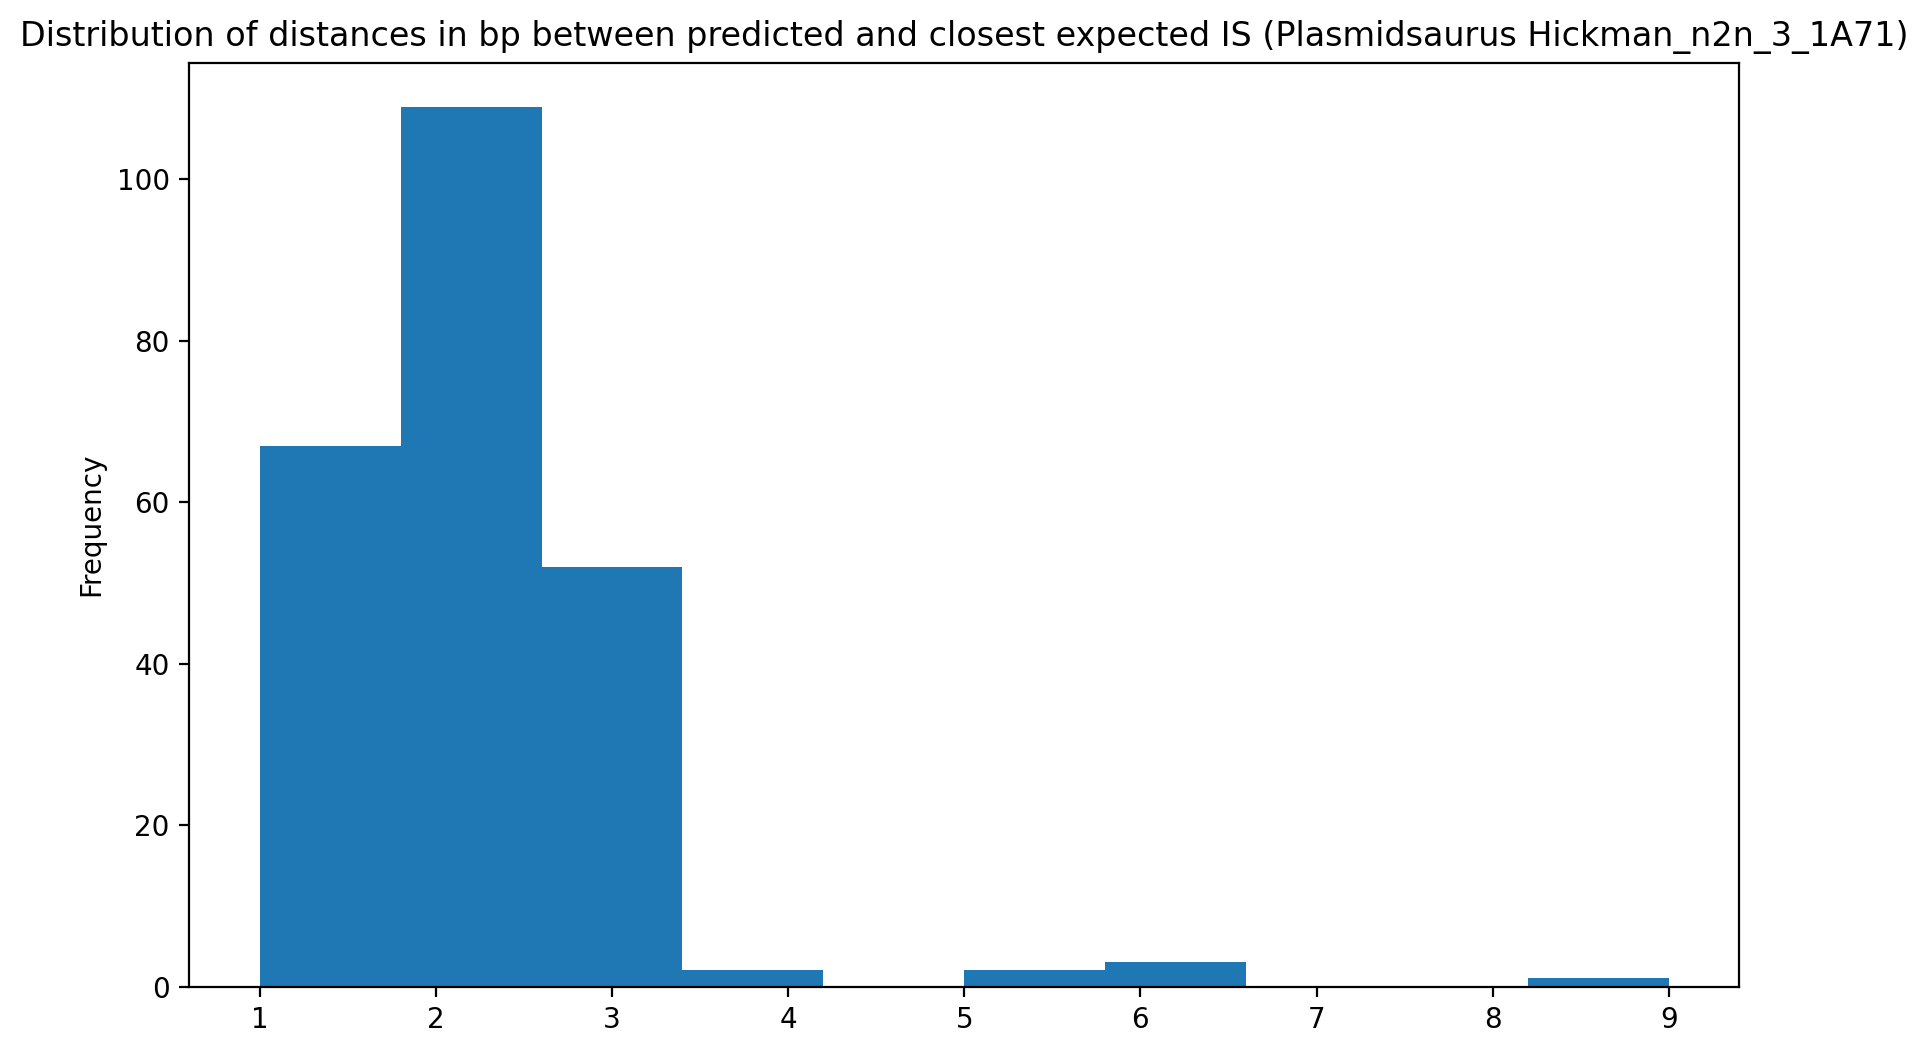

In [30]:
p2_hist = is_results_orig_hick_3['dist_p_e'].plot(kind='hist', 
                                title='Distribution of distances in bp between predicted and closest expected IS (Plasmidsaurus Hickman_n2n_3_1A71)',
                                xlabel='Predicted vs expected IS distance (bp)'
                               )
plt.show(p2_hist)

## Load plasmidsaurus modified HiHickman_n2n_4_6A95ckman_n2n_3_1A71 modified dataset

In [31]:
# Load blastn result
my_blastn_file = './PLASMIDSAURUS/Hickman_n2n_4_6A95_trimmed.filter.hits.flanking_vs_modified.NR.bn'
my_bed_file = './PLASMIDSAURUS/Hickman_n2n_4_6A95_trimmed.filter.hits.bed'

df_mod_hick_4 = upload_blastn_tab_file(blastn_file=my_blastn_file)
df_bed_hick_4 = pd.read_csv(my_bed_file, sep='\t', header=None, names=['read_id','end_5','end_3','is_coord'])

# Remove reads with unique blastn hits
#df_orig_dupl = remove_duplicates(df_orig)


# Identify IS sites
is_results_mod_hick_4 = quantify_IS_sites(blastn_df=df_mod_hick_4, 
                                    plasmid_name='modified', 
                                    my_bed_df=df_bed_hick_4
                                    )

# Calculate IS frequency
my_freq_mod_hick_4 = calculate_is_frequency(is_results_mod_hick_4,'modified')
my_freq_mod_expected_hick_4 = calculate_is_frequency_by_expected(is_results_mod_hick_4,'modified')

Counting IS sites:   0%|          | 0/2874 [00:00<?, ?it/s]

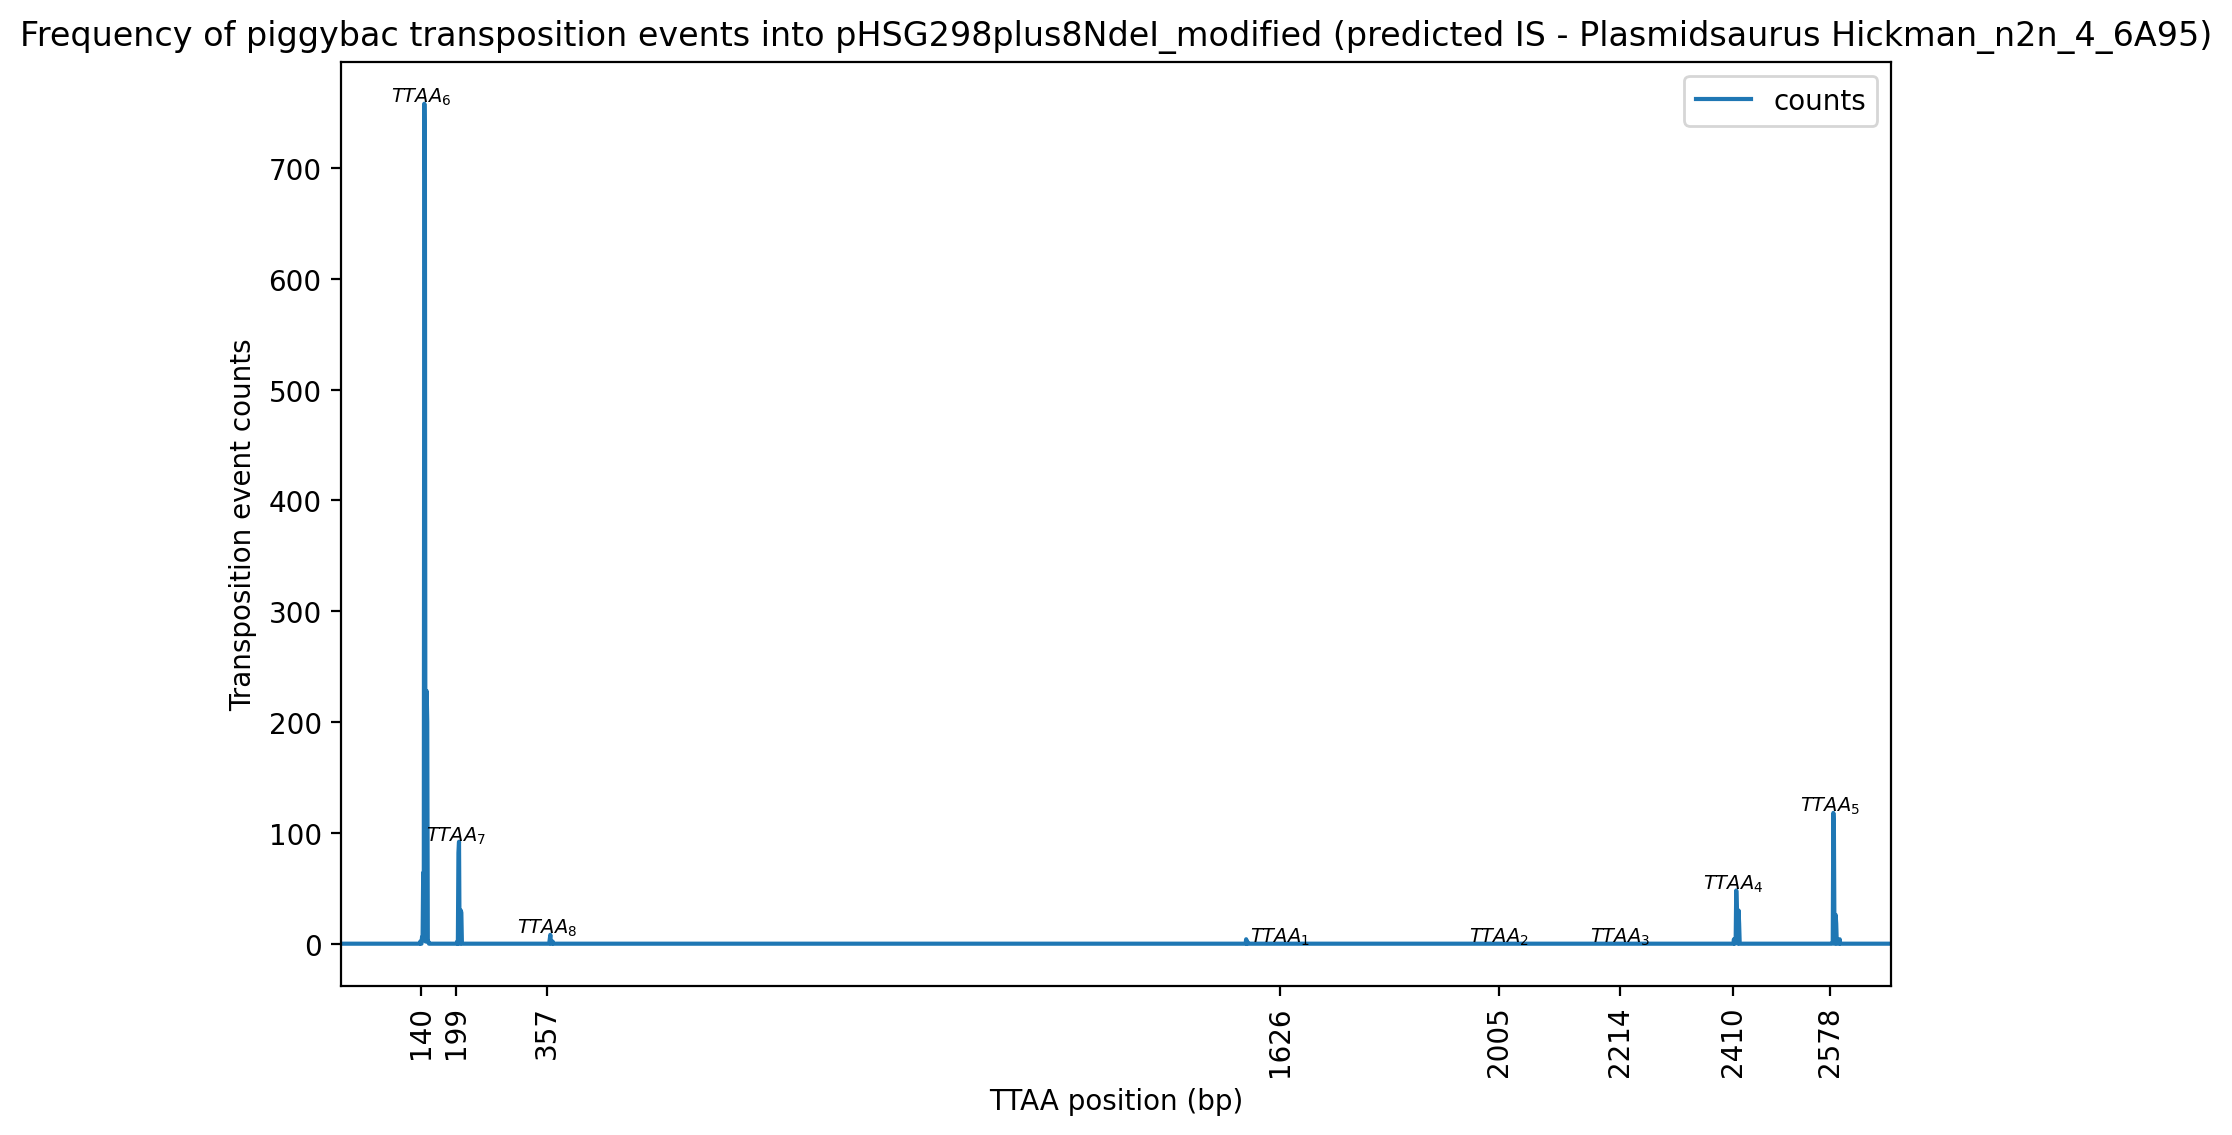

In [35]:
IS=[140,199,357,1626,2005,2214,2410,2578]

p1 = my_freq_mod_hick_4.plot(x='coords_x', y='counts',
            xlabel='TTAA position (bp)', 
            ylabel='Transposition event counts', 
            xlim=(1,2683),
            xticks=(140,199,357,1626,2005,2214,2410,2578),
            rot=90
            )

p1.set_title('Frequency of piggybac transposition events into pHSG298plus8NdeI_modified (predicted IS - Plasmidsaurus Hickman_n2n_4_6A95)')
p1.text(IS[0], my_freq_mod_hick_4.iloc[IS[0]-10:IS[0]+10]['counts'].max() + 2, "$TTAA_6$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[1], my_freq_mod_hick_4.iloc[IS[1]-10:IS[1]+10]['counts'].max() + 1, "$TTAA_7$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[2], my_freq_mod_hick_4.iloc[IS[2]-10:IS[2]+10]['counts'].max() + 2, "$TTAA_8$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[3], my_freq_mod_hick_4.iloc[IS[3]-10:IS[3]+10]['counts'].max() + 2, "$TTAA_1$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[4], my_freq_mod_hick_4.iloc[IS[4]-10:IS[4]+10]['counts'].max() + 2, "$TTAA_2$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[5], my_freq_mod_hick_4.iloc[IS[5]-10:IS[5]+10]['counts'].max() + 2, "$TTAA_3$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[6], my_freq_mod_hick_4.iloc[IS[6]-10:IS[6]+10]['counts'].max() + 2, "$TTAA_4$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[7], my_freq_mod_hick_4.iloc[IS[7]-10:IS[7]+10]['counts'].max() + 2, "$TTAA_5$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')

plt.show(p1)

fig = p1.get_figure()
fig.savefig('hick_4_vs_modified_predicted.pdf')

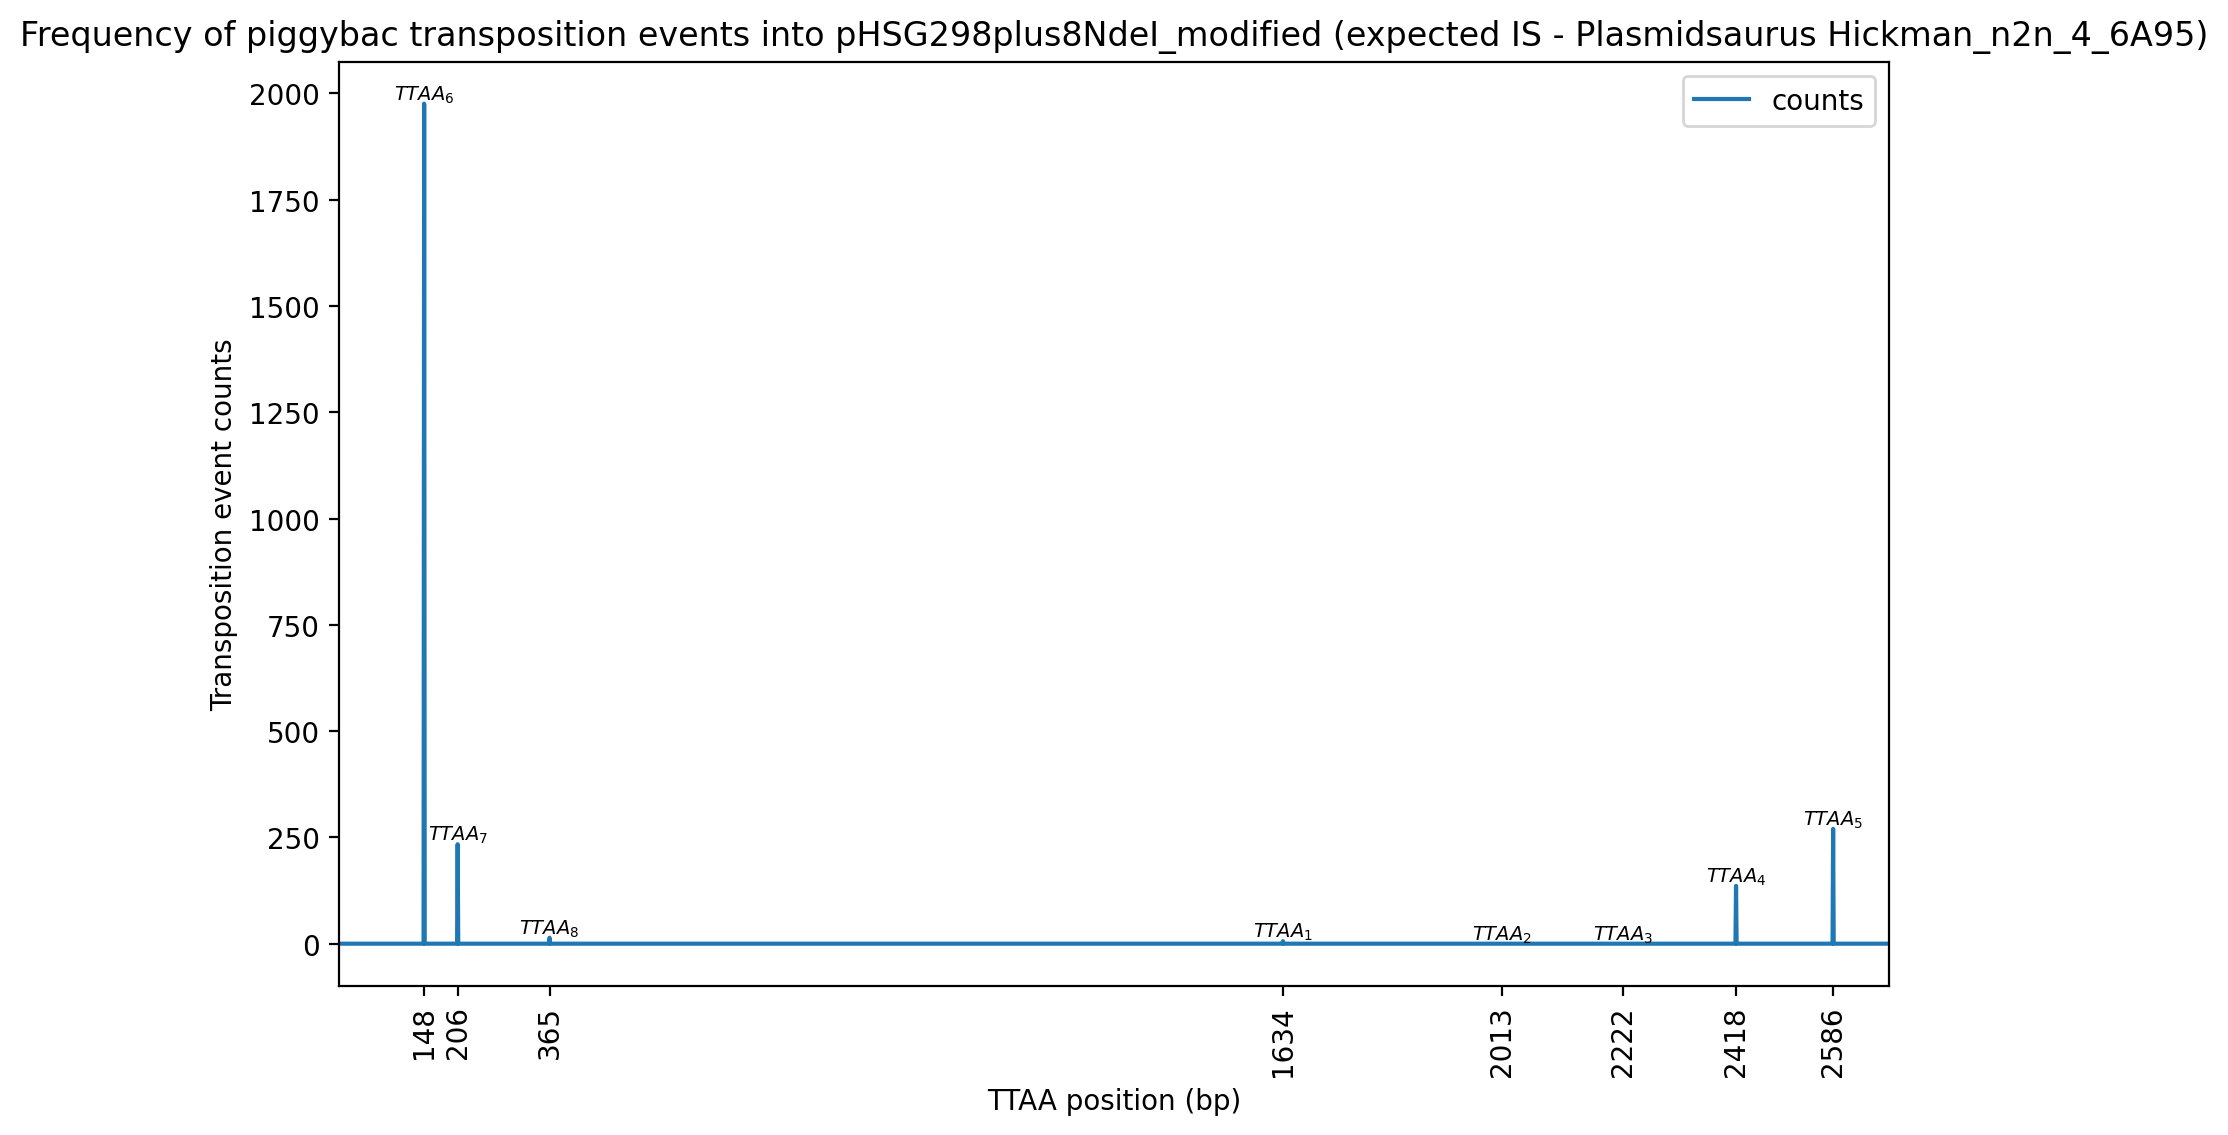

In [36]:
IS=[148,206,365,1634,2013,2222,2418,2586]

p1 = my_freq_mod_expected_hick_4.plot(x='coords_x', y='counts',
            xlabel='TTAA position (bp)', 
            ylabel='Transposition event counts', 
            xlim=(1,2683),
            xticks=(148,206,365,1634,2013,2222,2418,2586),
            rot=90
            )

p1.set_title('Frequency of piggybac transposition events into pHSG298plus8NdeI_modified (expected IS - Plasmidsaurus Hickman_n2n_4_6A95)')
p1.text(IS[0], my_freq_mod_expected_hick_4.iloc[IS[0]-10:IS[0]+10]['counts'].max() + 10, "$TTAA_6$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[1], my_freq_mod_expected_hick_4.iloc[IS[1]-10:IS[1]+10]['counts'].max() + 10, "$TTAA_7$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[2], my_freq_mod_expected_hick_4.iloc[IS[2]-10:IS[2]+10]['counts'].max() + 10, "$TTAA_8$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[3], my_freq_mod_expected_hick_4.iloc[IS[3]-10:IS[3]+10]['counts'].max() + 10, "$TTAA_1$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[4], my_freq_mod_expected_hick_4.iloc[IS[4]-10:IS[4]+10]['counts'].max() + 10, "$TTAA_2$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[5], my_freq_mod_expected_hick_4.iloc[IS[5]-10:IS[5]+10]['counts'].max() + 10, "$TTAA_3$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[6], my_freq_mod_expected_hick_4.iloc[IS[6]-10:IS[6]+10]['counts'].max() + 10, "$TTAA_4$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')
p1.text(IS[7], my_freq_mod_expected_hick_4.iloc[IS[7]-10:IS[7]+10]['counts'].max() + 10, "$TTAA_5$", horizontalalignment='center', fontsize='7', color='black', weight='semibold')

plt.show(p1)

fig = p1.get_figure()
fig.savefig('hick_4_vs_modified_expected.pdf')

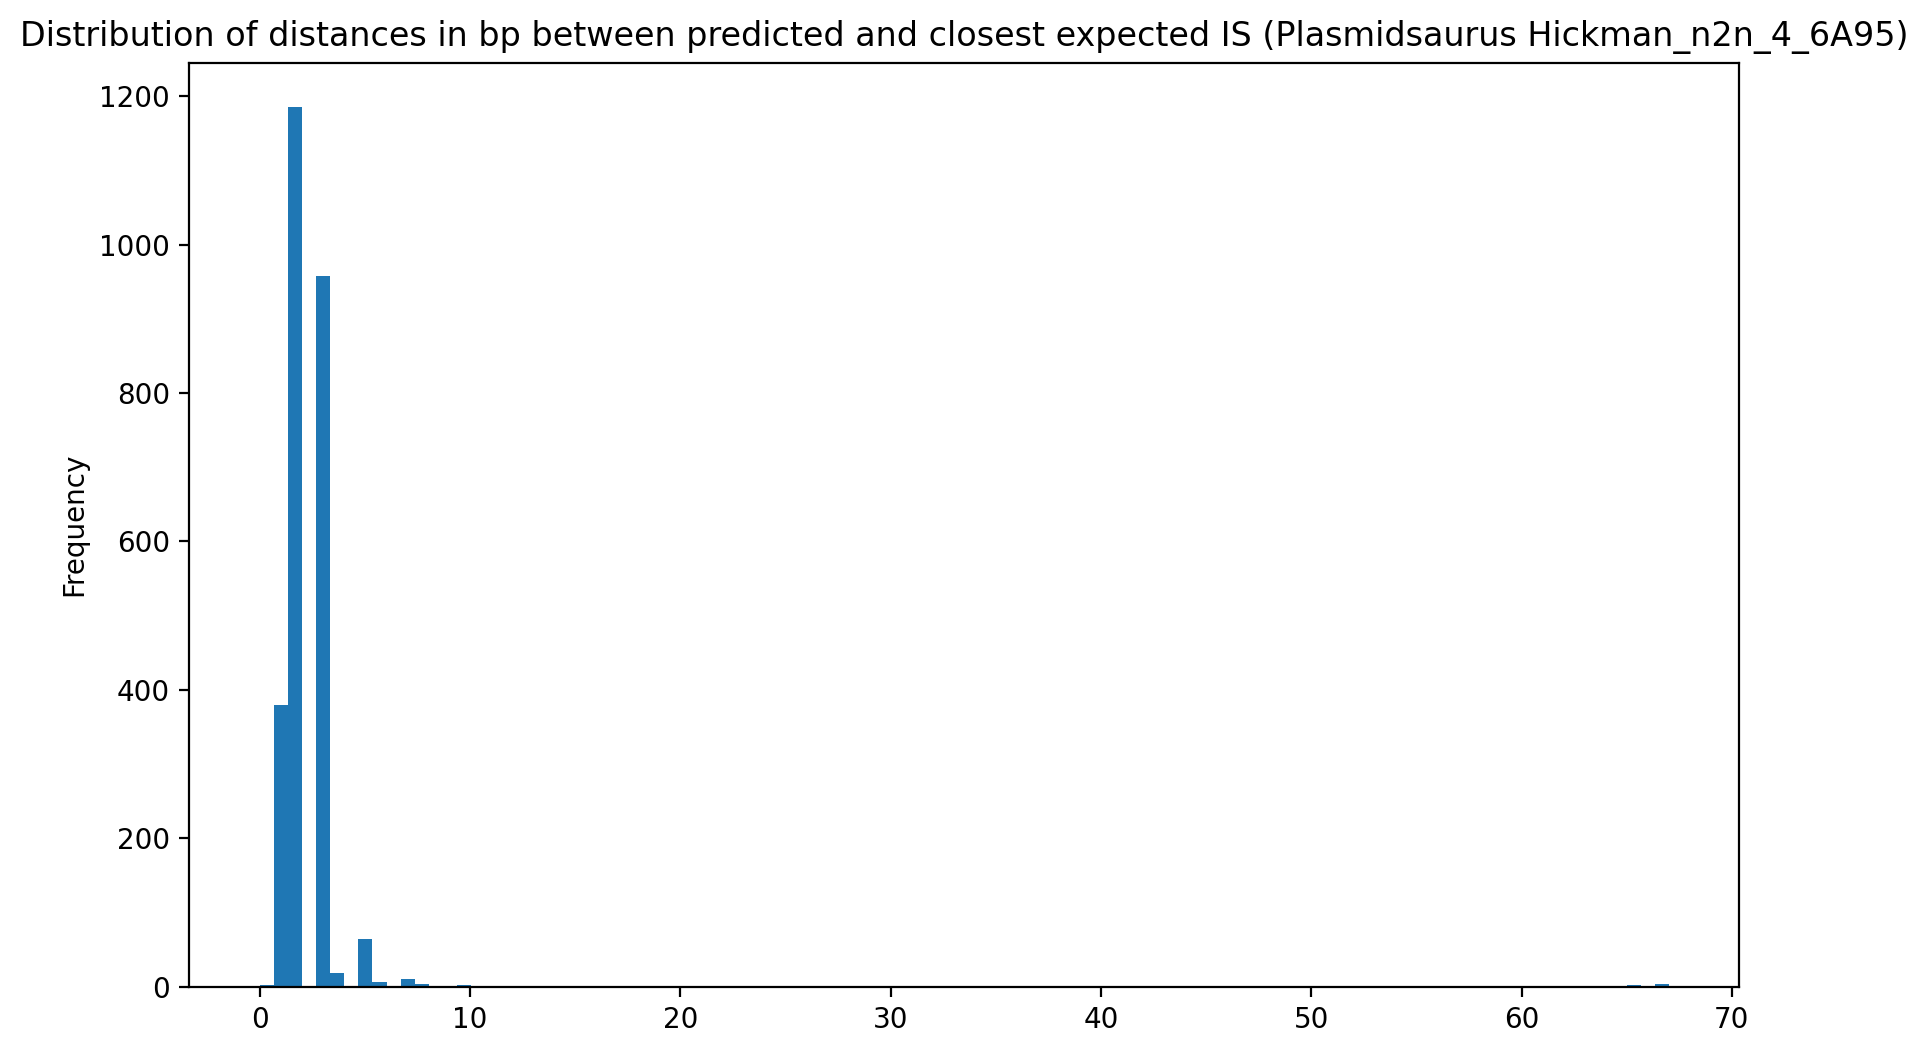

In [34]:
p2_hist = is_results_mod_hick_4['dist_p_e'].plot(kind='hist', bins=100,
                                title='Distribution of distances in bp between predicted and closest expected IS (Plasmidsaurus Hickman_n2n_4_6A95)',
                                xlabel='Predicted vs expected IS distance (bp)'
                               )
plt.show(p2_hist)